In [25]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

# Initial training

### Use the entire set, no cross validation
### Just normalised differenced PE as the training data

In [26]:
prediction_period = 12
dataset = pd.read_csv('./datasets/train.csv')
validation = pd.read_csv('./datasets/test.csv')
dataset.drop(["Unnamed: 0"], inplace=True, axis=1)
validation.drop(["Unnamed: 0"], inplace=True, axis=1)
validation = validation[['Month','Year', 'PE_Norm_Diff']]
dataset = dataset[['Month','Year', 'PE_Norm_Diff']]
validation = validation[['Month','Year', 'PE_Norm_Diff']]
dataset['Date'] = dataset['Year'].astype(str) +"-" +dataset['Month'].astype(str)
validation['Date'] = validation['Year'].astype(str) +"-" +validation['Month'].astype(str)
dataset.drop(["Month", "Year"], inplace=True, axis=1)
validation.drop(["Month", "Year"], inplace=True, axis=1)
dataset = dataset.rename(columns={"Date":"ds", "PE_Norm_Diff":"y"})
validation = validation.rename(columns={"Date":"ds", "PE_Norm_Diff":"y"})


12:39:38 - cmdstanpy - INFO - Chain [1] start processing
12:39:38 - cmdstanpy - INFO - Chain [1] done processing


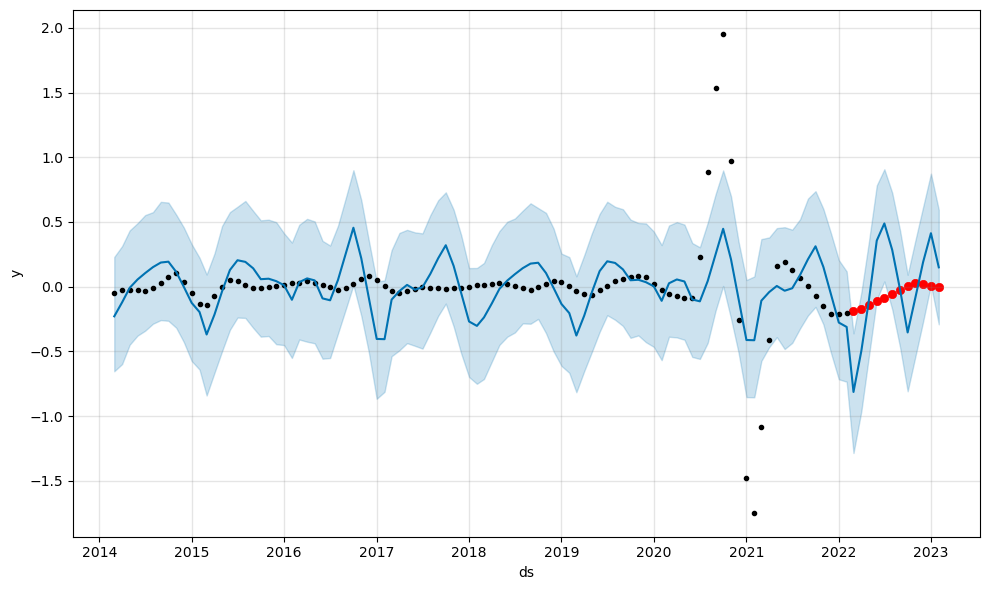

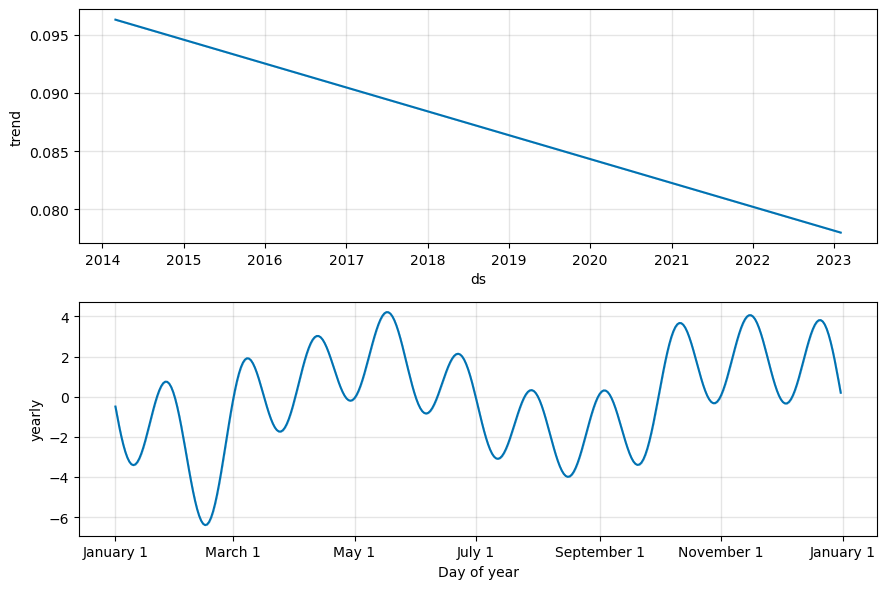

In [27]:

model = Prophet()
model.fit(dataset)
future = model.make_future_dataframe(periods=prediction_period, freq="M")
forecast = model.predict(future)
fig1 = model.plot(forecast)
plt.scatter(future['ds'][-prediction_period:], validation['y'][:prediction_period], color='r', linewidth=0.5)
fig2 = model.plot_components(forecast)



In [28]:

def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between two NumPy arrays.

    Parameters:
        y_true (numpy.ndarray): Array of true values.
        y_pred (numpy.ndarray): Array of predicted values.

    Returns:
        float: The MAPE between y_true and y_pred.
    """
    # Ensure the input arrays have the same shape
    assert y_true.shape == y_pred.shape, "Input arrays must have the same shape."

    # Calculate the absolute percentage error for each element
    abs_percentage_error = np.abs((y_true - y_pred) / y_true)

    # Calculate the mean of the absolute percentage errors
    mape = np.mean(abs_percentage_error) * 100

    return mape


In [29]:
pred = np.array(forecast['yhat'].tail(prediction_period))
true = np.array(validation['y'].head(prediction_period))
mape = calculate_mape(true, pred)

print("MAPE: {:.2f}%".format(mape))

MAPE: 1612.60%


### First lets try undifferncing and unnormalising the prediction and validation set

In [30]:
def revert_norm_diff_pe(pred):
    pred = np.array(pred)
    dataset_default = pd.read_csv('./datasets/merged.csv')
    mean = dataset_default['PE_mean'][0]
    std = dataset_default['PE_std'][0]
    pred_undifferenced = pred.cumsum() + dataset_default['PE_original_value'][0]
    pred_undifferenced_unnorm = pred_undifferenced * std + mean
    
    return pred_undifferenced_unnorm
dataset_default = pd.read_csv('./datasets/merged.csv')
dataset_default = dataset_default[['Month', 'Year', 'PE']]
test = pd.read_csv('./datasets/test.csv')
test = test[['Month', 'Year', 'PE']]

In [31]:


unnorm = revert_norm_diff_pe(forecast['yhat'].tail(prediction_period))
mape = calculate_mape(np.array(test['PE']), unnorm)
print("MAPE: {:.2f}%".format(mape))

MAPE: 57.65%


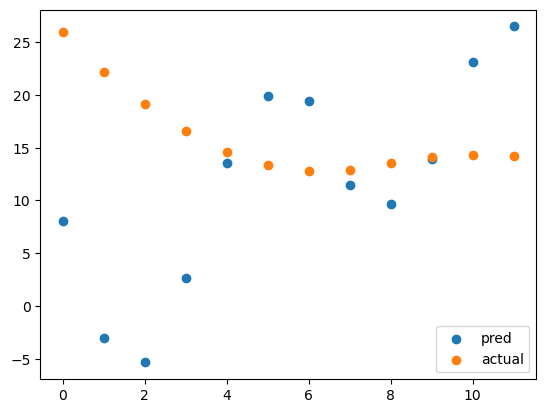

In [32]:
x = np.arange(12)
plt.scatter(x,unnorm,label="pred")
plt.scatter(x,test['PE'],label="actual")
plt.legend()

## MAPE of 116% isnt bad. Next steps:
* Add COVID as a "holiday" to reduce the impact of the lockdowns as shocks to the model. The following dates will be added:
    
    Using the following source: https://commonslibrary.parliament.uk/research-briefings/cbp-9068/
    
    March 2020 - March 2021
    
* Add more regressors 

In [33]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-1', 'lower_window': 0, 'ds_upper': '2021-03-31'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-01,0,2021-03-31,395


12:39:52 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,lockdown_1,lockdown_1_lower,lockdown_1_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-03-01,0.006028,-0.123733,0.039069,0.006028,0.006028,-0.050467,-0.050467,-0.050467,0.0,...,0.0,0.0,0.0,-0.050467,-0.050467,-0.050467,0.0,0.0,0.0,-0.044438
1,2014-04-01,0.006204,-0.150359,0.010320,0.006204,0.006204,-0.078594,-0.078594,-0.078594,0.0,...,0.0,0.0,0.0,-0.078594,-0.078594,-0.078594,0.0,0.0,0.0,-0.072390
2,2014-05-01,0.006374,-0.075380,0.091089,0.006374,0.006374,0.004303,0.004303,0.004303,0.0,...,0.0,0.0,0.0,0.004303,0.004303,0.004303,0.0,0.0,0.0,0.010677
3,2014-06-01,0.006550,-0.046901,0.111375,0.006550,0.006550,0.023343,0.023343,0.023343,0.0,...,0.0,0.0,0.0,0.023343,0.023343,0.023343,0.0,0.0,0.0,0.029893
4,2014-07-01,0.006720,-0.063788,0.105128,0.006720,0.006720,0.016378,0.016378,0.016378,0.0,...,0.0,0.0,0.0,0.016378,0.016378,0.016378,0.0,0.0,0.0,0.023098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2022-09-30,-0.087697,-0.174692,-0.007560,-0.088928,-0.086228,-0.005368,-0.005368,-0.005368,0.0,...,0.0,0.0,0.0,-0.005368,-0.005368,-0.005368,0.0,0.0,0.0,-0.093065
104,2022-10-31,-0.090828,-0.166188,-0.004047,-0.092321,-0.089063,0.004744,0.004744,0.004744,0.0,...,0.0,0.0,0.0,0.004744,0.004744,0.004744,0.0,0.0,0.0,-0.086084
105,2022-11-30,-0.093858,-0.184022,-0.015176,-0.095681,-0.091821,-0.001812,-0.001812,-0.001812,0.0,...,0.0,0.0,0.0,-0.001812,-0.001812,-0.001812,0.0,0.0,0.0,-0.095670
106,2022-12-31,-0.096988,-0.195493,-0.029520,-0.099165,-0.094573,-0.015754,-0.015754,-0.015754,0.0,...,0.0,0.0,0.0,-0.015754,-0.015754,-0.015754,0.0,0.0,0.0,-0.112742


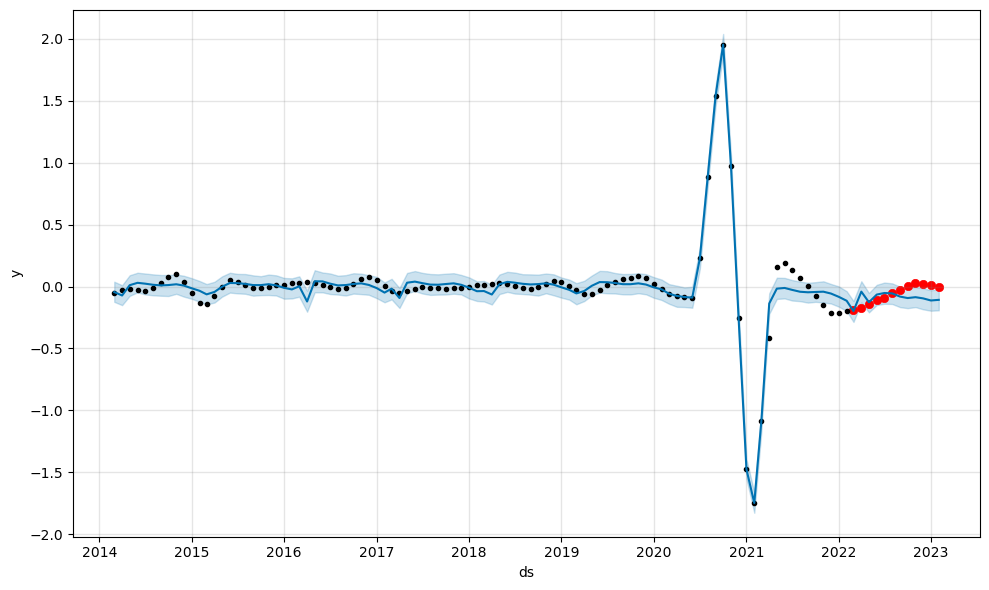

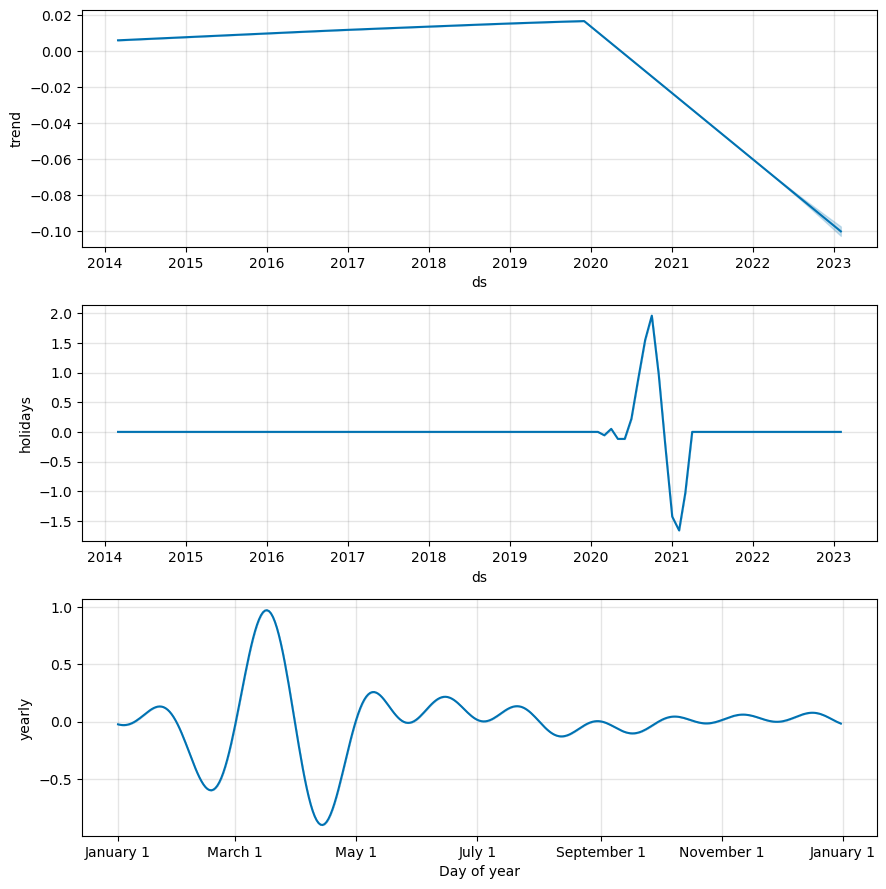

In [34]:
model2 = Prophet(holidays=lockdowns)
model2.fit(dataset)
future2 = model2.make_future_dataframe(periods=prediction_period, freq="M")
forecast2 = model2.predict(future2)
fig1 = model2.plot(forecast2)
plt.scatter(future2['ds'][-prediction_period:], validation['y'][:prediction_period], color='r', linewidth=0.5)
fig2 = model2.plot_components(forecast2)
forecast2

In [35]:
unnorm = revert_norm_diff_pe(forecast2['yhat'].tail(prediction_period))
mape = calculate_mape(np.array(test['PE']), unnorm)
print("MAPE: {:.2f}%".format(mape))

MAPE: 26.71%


# Now let's add more regressors 
## I'll add them 1 by 1 in order of the strongest correllation with PE_Norm_Diff from the EDA:
1) Unemployment_Norm_Diff

2) Productivity_Norm_Diff	

3) GDP_Norm_Diff	

4) compound

5) Interest Rate Norm Diff2	

6) CPIH_Norm_Diff_2

7) CPIH_Norm_Diff_2

8) Core_Norm_Diff2


In [36]:
regressor = 'Core_Norm_Diff2_lag_1'
list_of_features = ['Month','Year', 'PE_Norm_Diff', regressor]

dataset = pd.read_csv('./datasets/train.csv')
validation = pd.read_csv('./datasets/test.csv')
merged = pd.read_csv('./datasets/merged.csv')
merged.drop(["Unnamed: 0"], inplace=True, axis=1)
dataset.drop(["Unnamed: 0"], inplace=True, axis=1)
validation.drop(["Unnamed: 0"], inplace=True, axis=1)
validation = validation[list_of_features]
dataset = dataset[list_of_features]
merged = merged[list_of_features]
dataset['Date'] = dataset['Year'].astype(str) + "-" + dataset['Month'].astype(str)
validation['Date'] = validation['Year'].astype(str) + "-" +validation['Month'].astype(str)
dataset.drop(["Month", "Year"], inplace=True, axis=1)
validation.drop(["Month", "Year"], inplace=True, axis=1)
dataset = dataset.rename(columns={"Date":"ds", "PE_Norm_Diff":"y"})
validation = validation.rename(columns={"Date":"ds", "PE_Norm_Diff":"y"})

12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 26.45%


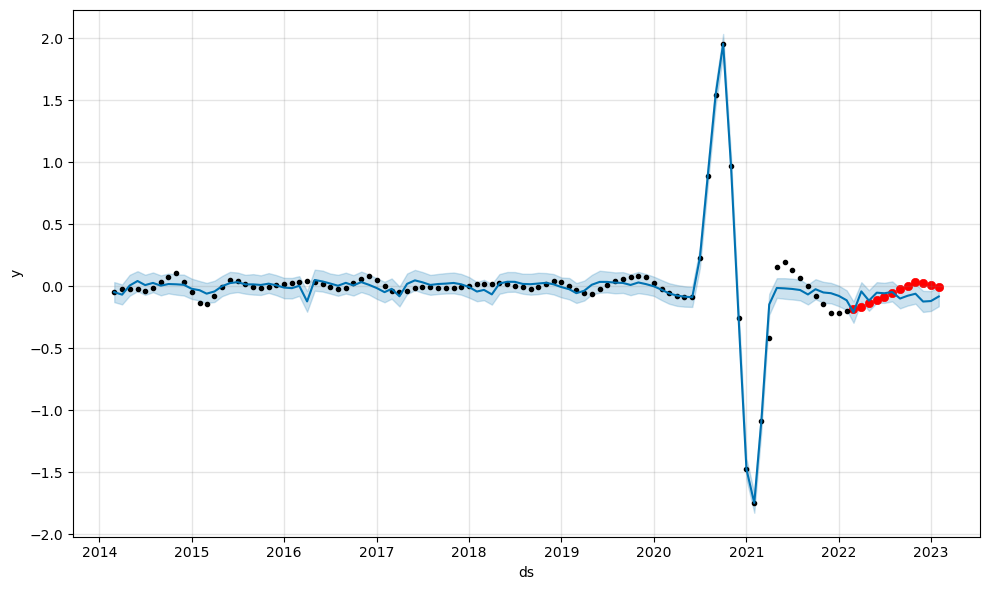

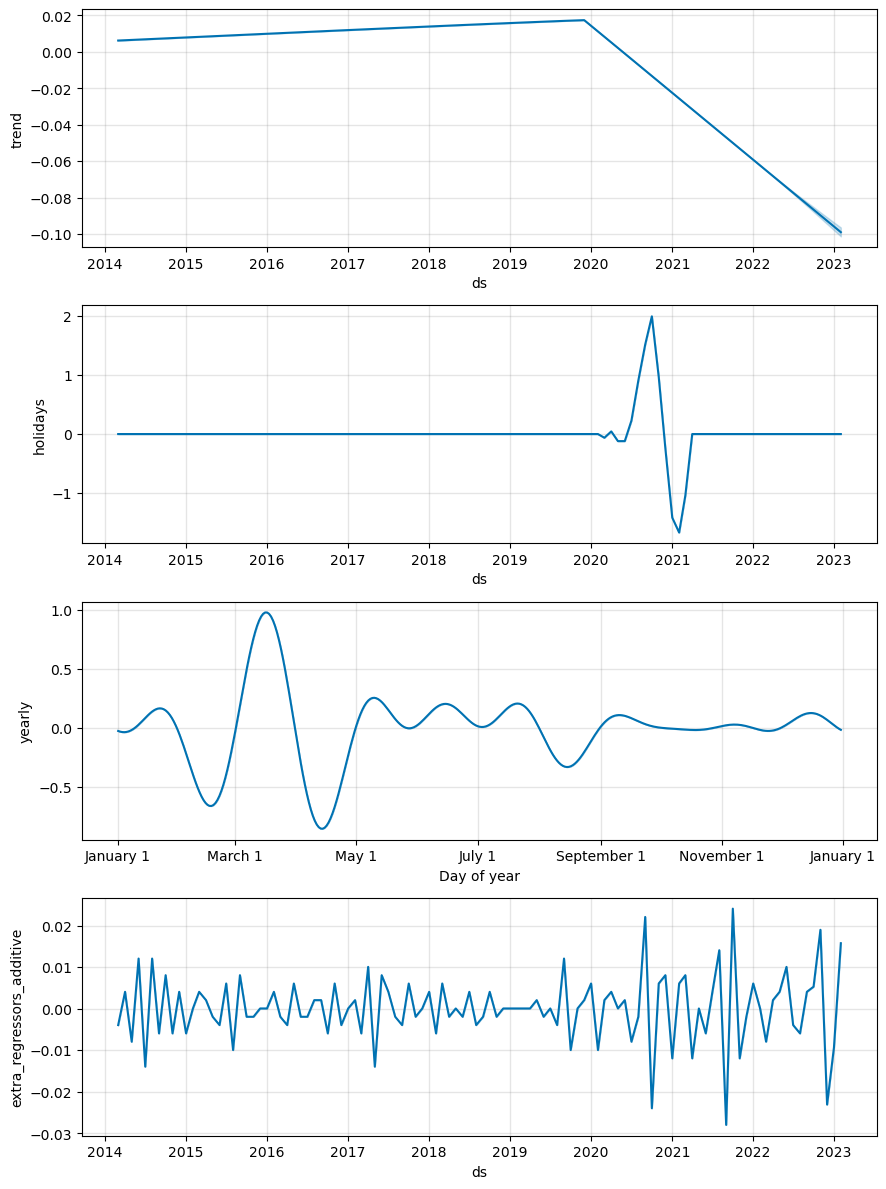

In [37]:
model = Prophet(holidays=lockdowns)
model.add_regressor(regressor)
model.fit(dataset)
future = model.make_future_dataframe(periods=prediction_period, freq="M")
future[regressor] = merged[regressor]
forecast = model.predict(future)
fig1 = model.plot(forecast)
plt.scatter(future['ds'][-prediction_period:], validation['y'][:prediction_period], color='r', linewidth=0.5)
fig2 = model.plot_components(forecast)
unnorm = revert_norm_diff_pe(forecast['yhat'].tail(prediction_period))
mape = calculate_mape(np.array(test['PE']), unnorm)
print("MAPE: {:.2f}%".format(mape))


## Individual regressor results: 

Unemployment_Norm_Diff_lag_2 : 90%

Productivity_Norm_Diff_lag_3 : 86.09%

Productivity_Norm_Diff_lag_7 : 83.47%

compound_lag_9 : 85.72%

Interest Rate Norm Diff2 lag 12 : 86.06%

CPIH_Norm_Diff_2_lag_2 : 85.03%

CPI_Norm_Diff_2_lag_2 : 85.18%

Core_Norm_Diff2_lag_1 : 86.23%

## Multiple regressors:

In [38]:

regressors = ['compound_lag_2', 'CPI_Norm_Diff_2_lag_2']
list_of_features = ['Month','Year', 'PE_Norm_Diff']
list_of_features += regressors

dataset = pd.read_csv('./datasets/train.csv')
validation = pd.read_csv('./datasets/test.csv')
merged = pd.read_csv('./datasets/merged.csv')
merged.drop(["Unnamed: 0"], inplace=True, axis=1)
dataset.drop(["Unnamed: 0"], inplace=True, axis=1)
validation.drop(["Unnamed: 0"], inplace=True, axis=1)
validation = validation[list_of_features]
dataset = dataset[list_of_features]
merged = merged[list_of_features]
dataset['Date'] = dataset['Year'].astype(str) + "-" + dataset['Month'].astype(str)
validation['Date'] = validation['Year'].astype(str) + "-" +validation['Month'].astype(str)
dataset.drop(["Month", "Year"], inplace=True, axis=1)
validation.drop(["Month", "Year"], inplace=True, axis=1)
dataset = dataset.rename(columns={"Date":"ds", "PE_Norm_Diff":"y"})
validation = validation.rename(columns={"Date":"ds", "PE_Norm_Diff":"y"})

model = Prophet(holidays=lockdowns)
for regressor in regressors:
    model.add_regressor(regressor)
model.fit(dataset)
future = model.make_future_dataframe(periods=prediction_period, freq="M")
future[regressors] = merged[regressors]
forecast = model.predict(future)
# fig1 = model.plot(forecast)
# plt.scatter(future['ds'][-prediction_period:], validation['y'][:prediction_period], color='r', linewidth=0.5)
# fig2 = model.plot_components(forecast)
unnorm = revert_norm_diff_pe(forecast['yhat'].tail(prediction_period))
mape = calculate_mape(np.array(test['PE']), unnorm)
print("MAPE: {:.2f}%".format(mape))


12:40:37 - cmdstanpy - INFO - Chain [1] start processing
12:40:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 40.48%


## Find the best performing lag from each feature

In [39]:
regressors = ['compound', 'CPI_Norm_Diff_2', 'Productivity_Norm_Diff', 'Core_Norm_Diff2',
             'Unemployment_Norm_Diff', 'GDP_Norm_Diff', 'CPIH_Norm_Diff_2']

regressor_results = {"compound" : [["compound"],[]],
                    "CPI_Norm_Diff_2" : [["CPI_Norm_Diff_2"],[]],
                    "Productivity_Norm_Diff" : [["Productivity_Norm_Diff"],[]],
                    "Core_Norm_Diff2" : [["Core_Norm_Diff2"],[]],
                    "Unemployment_Norm_Diff" : [["Unemployment_Norm_Diff"],[]],
                    "GDP_Norm_Diff" : [["GDP_Norm_Diff"],[]],
                    "CPIH_Norm_Diff_2" : [["CPIH_Norm_Diff_2"],[]]}

for k, v in regressor_results.items():
    for i in range(1,13):
        v[0].append(k + f"_lag_{i}")
        
regressor_results['Interest Rate Norm Diff2'] = [['Interest Rate Norm Diff2'],[]]
for i in range(1,13):
    regressor_results['Interest Rate Norm Diff2'][0].append('Interest Rate Norm Diff2' + f" lag {i}")

for k,v in regressor_results.items():
    for regressor in v[0]:
        
        regressors = [regressor]
        list_of_features = ['Month','Year', 'PE_Norm_Diff']
        list_of_features += regressors

        dataset = pd.read_csv('./datasets/train.csv')
        validation = pd.read_csv('./datasets/test.csv')
        merged = pd.read_csv('./datasets/merged.csv')
        merged.drop(["Unnamed: 0"], inplace=True, axis=1)
        dataset.drop(["Unnamed: 0"], inplace=True, axis=1)
        validation.drop(["Unnamed: 0"], inplace=True, axis=1)
        validation = validation[list_of_features]
        dataset = dataset[list_of_features]
        merged = merged[list_of_features]
        dataset['Date'] = dataset['Year'].astype(str) + "-" + dataset['Month'].astype(str)
        validation['Date'] = validation['Year'].astype(str) + "-" +validation['Month'].astype(str)
        dataset.drop(["Month", "Year"], inplace=True, axis=1)
        validation.drop(["Month", "Year"], inplace=True, axis=1)
        dataset = dataset.rename(columns={"Date":"ds", "PE_Norm_Diff":"y"})
        validation = validation.rename(columns={"Date":"ds", "PE_Norm_Diff":"y"})

        model = Prophet(holidays=lockdowns)
        for regressor in regressors:
            model.add_regressor(regressor)
        model.fit(dataset)
        future = model.make_future_dataframe(periods=prediction_period, freq="M")
        future[regressors] = merged[regressors]
        forecast = model.predict(future)
        # fig1 = model.plot(forecast)
        # plt.scatter(future['ds'][-prediction_period:], validation['y'][:prediction_period], color='r', linewidth=0.5)
        # fig2 = model.plot_components(forecast)
        unnorm = revert_norm_diff_pe(forecast['yhat'].tail(prediction_period))
        mape = calculate_mape(np.array(test['PE']), unnorm)
        print(f"Training with: {regressor}")
        print("MAPE: {:.2f}%".format(mape))
        v[1].append(mape)
        print(regressor_results[k])

12:40:49 - cmdstanpy - INFO - Chain [1] start processing
12:41:18 - cmdstanpy - INFO - Chain [1] done processing


Training with: compound
MAPE: 32.42%
[['compound', 'compound_lag_1', 'compound_lag_2', 'compound_lag_3', 'compound_lag_4', 'compound_lag_5', 'compound_lag_6', 'compound_lag_7', 'compound_lag_8', 'compound_lag_9', 'compound_lag_10', 'compound_lag_11', 'compound_lag_12'], [32.41845692538745]]


12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing


Training with: compound_lag_1
MAPE: 27.10%
[['compound', 'compound_lag_1', 'compound_lag_2', 'compound_lag_3', 'compound_lag_4', 'compound_lag_5', 'compound_lag_6', 'compound_lag_7', 'compound_lag_8', 'compound_lag_9', 'compound_lag_10', 'compound_lag_11', 'compound_lag_12'], [32.41845692538745, 27.097911104903076]]


12:41:32 - cmdstanpy - INFO - Chain [1] start processing
12:41:44 - cmdstanpy - INFO - Chain [1] done processing


Training with: compound_lag_2
MAPE: 41.05%
[['compound', 'compound_lag_1', 'compound_lag_2', 'compound_lag_3', 'compound_lag_4', 'compound_lag_5', 'compound_lag_6', 'compound_lag_7', 'compound_lag_8', 'compound_lag_9', 'compound_lag_10', 'compound_lag_11', 'compound_lag_12'], [32.41845692538745, 27.097911104903076, 41.04899989805838]]


12:41:45 - cmdstanpy - INFO - Chain [1] start processing
12:42:02 - cmdstanpy - INFO - Chain [1] done processing


Training with: compound_lag_3
MAPE: 33.74%
[['compound', 'compound_lag_1', 'compound_lag_2', 'compound_lag_3', 'compound_lag_4', 'compound_lag_5', 'compound_lag_6', 'compound_lag_7', 'compound_lag_8', 'compound_lag_9', 'compound_lag_10', 'compound_lag_11', 'compound_lag_12'], [32.41845692538745, 27.097911104903076, 41.04899989805838, 33.7441249824087]]


12:42:02 - cmdstanpy - INFO - Chain [1] start processing
12:42:20 - cmdstanpy - INFO - Chain [1] done processing


Training with: compound_lag_4
MAPE: 37.46%
[['compound', 'compound_lag_1', 'compound_lag_2', 'compound_lag_3', 'compound_lag_4', 'compound_lag_5', 'compound_lag_6', 'compound_lag_7', 'compound_lag_8', 'compound_lag_9', 'compound_lag_10', 'compound_lag_11', 'compound_lag_12'], [32.41845692538745, 27.097911104903076, 41.04899989805838, 33.7441249824087, 37.45763526334696]]


12:42:20 - cmdstanpy - INFO - Chain [1] start processing
12:42:35 - cmdstanpy - INFO - Chain [1] done processing


Training with: compound_lag_5
MAPE: 25.57%
[['compound', 'compound_lag_1', 'compound_lag_2', 'compound_lag_3', 'compound_lag_4', 'compound_lag_5', 'compound_lag_6', 'compound_lag_7', 'compound_lag_8', 'compound_lag_9', 'compound_lag_10', 'compound_lag_11', 'compound_lag_12'], [32.41845692538745, 27.097911104903076, 41.04899989805838, 33.7441249824087, 37.45763526334696, 25.57174615713947]]


12:42:36 - cmdstanpy - INFO - Chain [1] start processing
12:42:53 - cmdstanpy - INFO - Chain [1] done processing


Training with: compound_lag_6
MAPE: 21.24%
[['compound', 'compound_lag_1', 'compound_lag_2', 'compound_lag_3', 'compound_lag_4', 'compound_lag_5', 'compound_lag_6', 'compound_lag_7', 'compound_lag_8', 'compound_lag_9', 'compound_lag_10', 'compound_lag_11', 'compound_lag_12'], [32.41845692538745, 27.097911104903076, 41.04899989805838, 33.7441249824087, 37.45763526334696, 25.57174615713947, 21.238422538139915]]


12:42:54 - cmdstanpy - INFO - Chain [1] start processing
12:43:05 - cmdstanpy - INFO - Chain [1] done processing


Training with: compound_lag_7
MAPE: 20.66%
[['compound', 'compound_lag_1', 'compound_lag_2', 'compound_lag_3', 'compound_lag_4', 'compound_lag_5', 'compound_lag_6', 'compound_lag_7', 'compound_lag_8', 'compound_lag_9', 'compound_lag_10', 'compound_lag_11', 'compound_lag_12'], [32.41845692538745, 27.097911104903076, 41.04899989805838, 33.7441249824087, 37.45763526334696, 25.57174615713947, 21.238422538139915, 20.657732374543617]]


12:43:05 - cmdstanpy - INFO - Chain [1] start processing
12:43:19 - cmdstanpy - INFO - Chain [1] done processing


Training with: compound_lag_8
MAPE: 19.98%
[['compound', 'compound_lag_1', 'compound_lag_2', 'compound_lag_3', 'compound_lag_4', 'compound_lag_5', 'compound_lag_6', 'compound_lag_7', 'compound_lag_8', 'compound_lag_9', 'compound_lag_10', 'compound_lag_11', 'compound_lag_12'], [32.41845692538745, 27.097911104903076, 41.04899989805838, 33.7441249824087, 37.45763526334696, 25.57174615713947, 21.238422538139915, 20.657732374543617, 19.981937432512087]]


12:43:19 - cmdstanpy - INFO - Chain [1] start processing
12:43:32 - cmdstanpy - INFO - Chain [1] done processing


Training with: compound_lag_9
MAPE: 27.22%
[['compound', 'compound_lag_1', 'compound_lag_2', 'compound_lag_3', 'compound_lag_4', 'compound_lag_5', 'compound_lag_6', 'compound_lag_7', 'compound_lag_8', 'compound_lag_9', 'compound_lag_10', 'compound_lag_11', 'compound_lag_12'], [32.41845692538745, 27.097911104903076, 41.04899989805838, 33.7441249824087, 37.45763526334696, 25.57174615713947, 21.238422538139915, 20.657732374543617, 19.981937432512087, 27.21921666818824]]


12:43:33 - cmdstanpy - INFO - Chain [1] start processing
12:43:47 - cmdstanpy - INFO - Chain [1] done processing


Training with: compound_lag_10
MAPE: 26.90%
[['compound', 'compound_lag_1', 'compound_lag_2', 'compound_lag_3', 'compound_lag_4', 'compound_lag_5', 'compound_lag_6', 'compound_lag_7', 'compound_lag_8', 'compound_lag_9', 'compound_lag_10', 'compound_lag_11', 'compound_lag_12'], [32.41845692538745, 27.097911104903076, 41.04899989805838, 33.7441249824087, 37.45763526334696, 25.57174615713947, 21.238422538139915, 20.657732374543617, 19.981937432512087, 27.21921666818824, 26.898943846176472]]


12:43:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:38 - cmdstanpy - INFO - Chain [1] done processing


Training with: compound_lag_11
MAPE: 26.95%
[['compound', 'compound_lag_1', 'compound_lag_2', 'compound_lag_3', 'compound_lag_4', 'compound_lag_5', 'compound_lag_6', 'compound_lag_7', 'compound_lag_8', 'compound_lag_9', 'compound_lag_10', 'compound_lag_11', 'compound_lag_12'], [32.41845692538745, 27.097911104903076, 41.04899989805838, 33.7441249824087, 37.45763526334696, 25.57174615713947, 21.238422538139915, 20.657732374543617, 19.981937432512087, 27.21921666818824, 26.898943846176472, 26.949976048197694]]


12:44:39 - cmdstanpy - INFO - Chain [1] start processing
12:44:52 - cmdstanpy - INFO - Chain [1] done processing


Training with: compound_lag_12
MAPE: 28.38%
[['compound', 'compound_lag_1', 'compound_lag_2', 'compound_lag_3', 'compound_lag_4', 'compound_lag_5', 'compound_lag_6', 'compound_lag_7', 'compound_lag_8', 'compound_lag_9', 'compound_lag_10', 'compound_lag_11', 'compound_lag_12'], [32.41845692538745, 27.097911104903076, 41.04899989805838, 33.7441249824087, 37.45763526334696, 25.57174615713947, 21.238422538139915, 20.657732374543617, 19.981937432512087, 27.21921666818824, 26.898943846176472, 26.949976048197694, 28.37891450349425]]


12:44:53 - cmdstanpy - INFO - Chain [1] start processing
12:45:07 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPI_Norm_Diff_2
MAPE: 27.28%
[['CPI_Norm_Diff_2', 'CPI_Norm_Diff_2_lag_1', 'CPI_Norm_Diff_2_lag_2', 'CPI_Norm_Diff_2_lag_3', 'CPI_Norm_Diff_2_lag_4', 'CPI_Norm_Diff_2_lag_5', 'CPI_Norm_Diff_2_lag_6', 'CPI_Norm_Diff_2_lag_7', 'CPI_Norm_Diff_2_lag_8', 'CPI_Norm_Diff_2_lag_9', 'CPI_Norm_Diff_2_lag_10', 'CPI_Norm_Diff_2_lag_11', 'CPI_Norm_Diff_2_lag_12'], [27.282176037243506]]


12:45:08 - cmdstanpy - INFO - Chain [1] start processing
12:45:25 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPI_Norm_Diff_2_lag_1
MAPE: 26.52%
[['CPI_Norm_Diff_2', 'CPI_Norm_Diff_2_lag_1', 'CPI_Norm_Diff_2_lag_2', 'CPI_Norm_Diff_2_lag_3', 'CPI_Norm_Diff_2_lag_4', 'CPI_Norm_Diff_2_lag_5', 'CPI_Norm_Diff_2_lag_6', 'CPI_Norm_Diff_2_lag_7', 'CPI_Norm_Diff_2_lag_8', 'CPI_Norm_Diff_2_lag_9', 'CPI_Norm_Diff_2_lag_10', 'CPI_Norm_Diff_2_lag_11', 'CPI_Norm_Diff_2_lag_12'], [27.282176037243506, 26.523604614598423]]


12:45:25 - cmdstanpy - INFO - Chain [1] start processing
12:45:39 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPI_Norm_Diff_2_lag_2
MAPE: 28.46%
[['CPI_Norm_Diff_2', 'CPI_Norm_Diff_2_lag_1', 'CPI_Norm_Diff_2_lag_2', 'CPI_Norm_Diff_2_lag_3', 'CPI_Norm_Diff_2_lag_4', 'CPI_Norm_Diff_2_lag_5', 'CPI_Norm_Diff_2_lag_6', 'CPI_Norm_Diff_2_lag_7', 'CPI_Norm_Diff_2_lag_8', 'CPI_Norm_Diff_2_lag_9', 'CPI_Norm_Diff_2_lag_10', 'CPI_Norm_Diff_2_lag_11', 'CPI_Norm_Diff_2_lag_12'], [27.282176037243506, 26.523604614598423, 28.45586885471498]]


12:45:39 - cmdstanpy - INFO - Chain [1] start processing
12:46:02 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPI_Norm_Diff_2_lag_3
MAPE: 24.04%
[['CPI_Norm_Diff_2', 'CPI_Norm_Diff_2_lag_1', 'CPI_Norm_Diff_2_lag_2', 'CPI_Norm_Diff_2_lag_3', 'CPI_Norm_Diff_2_lag_4', 'CPI_Norm_Diff_2_lag_5', 'CPI_Norm_Diff_2_lag_6', 'CPI_Norm_Diff_2_lag_7', 'CPI_Norm_Diff_2_lag_8', 'CPI_Norm_Diff_2_lag_9', 'CPI_Norm_Diff_2_lag_10', 'CPI_Norm_Diff_2_lag_11', 'CPI_Norm_Diff_2_lag_12'], [27.282176037243506, 26.523604614598423, 28.45586885471498, 24.037496374154323]]


12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:25 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPI_Norm_Diff_2_lag_4
MAPE: 21.60%
[['CPI_Norm_Diff_2', 'CPI_Norm_Diff_2_lag_1', 'CPI_Norm_Diff_2_lag_2', 'CPI_Norm_Diff_2_lag_3', 'CPI_Norm_Diff_2_lag_4', 'CPI_Norm_Diff_2_lag_5', 'CPI_Norm_Diff_2_lag_6', 'CPI_Norm_Diff_2_lag_7', 'CPI_Norm_Diff_2_lag_8', 'CPI_Norm_Diff_2_lag_9', 'CPI_Norm_Diff_2_lag_10', 'CPI_Norm_Diff_2_lag_11', 'CPI_Norm_Diff_2_lag_12'], [27.282176037243506, 26.523604614598423, 28.45586885471498, 24.037496374154323, 21.600634852948268]]


12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:52 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPI_Norm_Diff_2_lag_5
MAPE: 27.58%
[['CPI_Norm_Diff_2', 'CPI_Norm_Diff_2_lag_1', 'CPI_Norm_Diff_2_lag_2', 'CPI_Norm_Diff_2_lag_3', 'CPI_Norm_Diff_2_lag_4', 'CPI_Norm_Diff_2_lag_5', 'CPI_Norm_Diff_2_lag_6', 'CPI_Norm_Diff_2_lag_7', 'CPI_Norm_Diff_2_lag_8', 'CPI_Norm_Diff_2_lag_9', 'CPI_Norm_Diff_2_lag_10', 'CPI_Norm_Diff_2_lag_11', 'CPI_Norm_Diff_2_lag_12'], [27.282176037243506, 26.523604614598423, 28.45586885471498, 24.037496374154323, 21.600634852948268, 27.575525454337225]]


12:46:56 - cmdstanpy - INFO - Chain [1] start processing
12:47:15 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPI_Norm_Diff_2_lag_6
MAPE: 25.40%
[['CPI_Norm_Diff_2', 'CPI_Norm_Diff_2_lag_1', 'CPI_Norm_Diff_2_lag_2', 'CPI_Norm_Diff_2_lag_3', 'CPI_Norm_Diff_2_lag_4', 'CPI_Norm_Diff_2_lag_5', 'CPI_Norm_Diff_2_lag_6', 'CPI_Norm_Diff_2_lag_7', 'CPI_Norm_Diff_2_lag_8', 'CPI_Norm_Diff_2_lag_9', 'CPI_Norm_Diff_2_lag_10', 'CPI_Norm_Diff_2_lag_11', 'CPI_Norm_Diff_2_lag_12'], [27.282176037243506, 26.523604614598423, 28.45586885471498, 24.037496374154323, 21.600634852948268, 27.575525454337225, 25.400980149830843]]


12:47:15 - cmdstanpy - INFO - Chain [1] start processing
12:47:36 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPI_Norm_Diff_2_lag_7
MAPE: 30.61%
[['CPI_Norm_Diff_2', 'CPI_Norm_Diff_2_lag_1', 'CPI_Norm_Diff_2_lag_2', 'CPI_Norm_Diff_2_lag_3', 'CPI_Norm_Diff_2_lag_4', 'CPI_Norm_Diff_2_lag_5', 'CPI_Norm_Diff_2_lag_6', 'CPI_Norm_Diff_2_lag_7', 'CPI_Norm_Diff_2_lag_8', 'CPI_Norm_Diff_2_lag_9', 'CPI_Norm_Diff_2_lag_10', 'CPI_Norm_Diff_2_lag_11', 'CPI_Norm_Diff_2_lag_12'], [27.282176037243506, 26.523604614598423, 28.45586885471498, 24.037496374154323, 21.600634852948268, 27.575525454337225, 25.400980149830843, 30.61256245533143]]


12:47:37 - cmdstanpy - INFO - Chain [1] start processing
12:47:56 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPI_Norm_Diff_2_lag_8
MAPE: 28.81%
[['CPI_Norm_Diff_2', 'CPI_Norm_Diff_2_lag_1', 'CPI_Norm_Diff_2_lag_2', 'CPI_Norm_Diff_2_lag_3', 'CPI_Norm_Diff_2_lag_4', 'CPI_Norm_Diff_2_lag_5', 'CPI_Norm_Diff_2_lag_6', 'CPI_Norm_Diff_2_lag_7', 'CPI_Norm_Diff_2_lag_8', 'CPI_Norm_Diff_2_lag_9', 'CPI_Norm_Diff_2_lag_10', 'CPI_Norm_Diff_2_lag_11', 'CPI_Norm_Diff_2_lag_12'], [27.282176037243506, 26.523604614598423, 28.45586885471498, 24.037496374154323, 21.600634852948268, 27.575525454337225, 25.400980149830843, 30.61256245533143, 28.810071239918813]]


12:47:57 - cmdstanpy - INFO - Chain [1] start processing
12:48:17 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPI_Norm_Diff_2_lag_9
MAPE: 23.49%
[['CPI_Norm_Diff_2', 'CPI_Norm_Diff_2_lag_1', 'CPI_Norm_Diff_2_lag_2', 'CPI_Norm_Diff_2_lag_3', 'CPI_Norm_Diff_2_lag_4', 'CPI_Norm_Diff_2_lag_5', 'CPI_Norm_Diff_2_lag_6', 'CPI_Norm_Diff_2_lag_7', 'CPI_Norm_Diff_2_lag_8', 'CPI_Norm_Diff_2_lag_9', 'CPI_Norm_Diff_2_lag_10', 'CPI_Norm_Diff_2_lag_11', 'CPI_Norm_Diff_2_lag_12'], [27.282176037243506, 26.523604614598423, 28.45586885471498, 24.037496374154323, 21.600634852948268, 27.575525454337225, 25.400980149830843, 30.61256245533143, 28.810071239918813, 23.485363173748063]]


12:48:17 - cmdstanpy - INFO - Chain [1] start processing
12:48:39 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPI_Norm_Diff_2_lag_10
MAPE: 24.44%
[['CPI_Norm_Diff_2', 'CPI_Norm_Diff_2_lag_1', 'CPI_Norm_Diff_2_lag_2', 'CPI_Norm_Diff_2_lag_3', 'CPI_Norm_Diff_2_lag_4', 'CPI_Norm_Diff_2_lag_5', 'CPI_Norm_Diff_2_lag_6', 'CPI_Norm_Diff_2_lag_7', 'CPI_Norm_Diff_2_lag_8', 'CPI_Norm_Diff_2_lag_9', 'CPI_Norm_Diff_2_lag_10', 'CPI_Norm_Diff_2_lag_11', 'CPI_Norm_Diff_2_lag_12'], [27.282176037243506, 26.523604614598423, 28.45586885471498, 24.037496374154323, 21.600634852948268, 27.575525454337225, 25.400980149830843, 30.61256245533143, 28.810071239918813, 23.485363173748063, 24.436393670306273]]


12:48:39 - cmdstanpy - INFO - Chain [1] start processing
12:48:57 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPI_Norm_Diff_2_lag_11
MAPE: 26.52%
[['CPI_Norm_Diff_2', 'CPI_Norm_Diff_2_lag_1', 'CPI_Norm_Diff_2_lag_2', 'CPI_Norm_Diff_2_lag_3', 'CPI_Norm_Diff_2_lag_4', 'CPI_Norm_Diff_2_lag_5', 'CPI_Norm_Diff_2_lag_6', 'CPI_Norm_Diff_2_lag_7', 'CPI_Norm_Diff_2_lag_8', 'CPI_Norm_Diff_2_lag_9', 'CPI_Norm_Diff_2_lag_10', 'CPI_Norm_Diff_2_lag_11', 'CPI_Norm_Diff_2_lag_12'], [27.282176037243506, 26.523604614598423, 28.45586885471498, 24.037496374154323, 21.600634852948268, 27.575525454337225, 25.400980149830843, 30.61256245533143, 28.810071239918813, 23.485363173748063, 24.436393670306273, 26.524145839586815]]


12:48:58 - cmdstanpy - INFO - Chain [1] start processing
12:49:13 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPI_Norm_Diff_2_lag_12
MAPE: 23.82%
[['CPI_Norm_Diff_2', 'CPI_Norm_Diff_2_lag_1', 'CPI_Norm_Diff_2_lag_2', 'CPI_Norm_Diff_2_lag_3', 'CPI_Norm_Diff_2_lag_4', 'CPI_Norm_Diff_2_lag_5', 'CPI_Norm_Diff_2_lag_6', 'CPI_Norm_Diff_2_lag_7', 'CPI_Norm_Diff_2_lag_8', 'CPI_Norm_Diff_2_lag_9', 'CPI_Norm_Diff_2_lag_10', 'CPI_Norm_Diff_2_lag_11', 'CPI_Norm_Diff_2_lag_12'], [27.282176037243506, 26.523604614598423, 28.45586885471498, 24.037496374154323, 21.600634852948268, 27.575525454337225, 25.400980149830843, 30.61256245533143, 28.810071239918813, 23.485363173748063, 24.436393670306273, 26.524145839586815, 23.823214072081964]]


12:49:13 - cmdstanpy - INFO - Chain [1] start processing
12:49:24 - cmdstanpy - INFO - Chain [1] done processing


Training with: Productivity_Norm_Diff
MAPE: 27.56%
[['Productivity_Norm_Diff', 'Productivity_Norm_Diff_lag_1', 'Productivity_Norm_Diff_lag_2', 'Productivity_Norm_Diff_lag_3', 'Productivity_Norm_Diff_lag_4', 'Productivity_Norm_Diff_lag_5', 'Productivity_Norm_Diff_lag_6', 'Productivity_Norm_Diff_lag_7', 'Productivity_Norm_Diff_lag_8', 'Productivity_Norm_Diff_lag_9', 'Productivity_Norm_Diff_lag_10', 'Productivity_Norm_Diff_lag_11', 'Productivity_Norm_Diff_lag_12'], [27.56065833587221]]


12:49:24 - cmdstanpy - INFO - Chain [1] start processing
12:49:41 - cmdstanpy - INFO - Chain [1] done processing


Training with: Productivity_Norm_Diff_lag_1
MAPE: 23.63%
[['Productivity_Norm_Diff', 'Productivity_Norm_Diff_lag_1', 'Productivity_Norm_Diff_lag_2', 'Productivity_Norm_Diff_lag_3', 'Productivity_Norm_Diff_lag_4', 'Productivity_Norm_Diff_lag_5', 'Productivity_Norm_Diff_lag_6', 'Productivity_Norm_Diff_lag_7', 'Productivity_Norm_Diff_lag_8', 'Productivity_Norm_Diff_lag_9', 'Productivity_Norm_Diff_lag_10', 'Productivity_Norm_Diff_lag_11', 'Productivity_Norm_Diff_lag_12'], [27.56065833587221, 23.633750845385716]]


12:49:42 - cmdstanpy - INFO - Chain [1] start processing
12:49:57 - cmdstanpy - INFO - Chain [1] done processing


Training with: Productivity_Norm_Diff_lag_2
MAPE: 25.82%
[['Productivity_Norm_Diff', 'Productivity_Norm_Diff_lag_1', 'Productivity_Norm_Diff_lag_2', 'Productivity_Norm_Diff_lag_3', 'Productivity_Norm_Diff_lag_4', 'Productivity_Norm_Diff_lag_5', 'Productivity_Norm_Diff_lag_6', 'Productivity_Norm_Diff_lag_7', 'Productivity_Norm_Diff_lag_8', 'Productivity_Norm_Diff_lag_9', 'Productivity_Norm_Diff_lag_10', 'Productivity_Norm_Diff_lag_11', 'Productivity_Norm_Diff_lag_12'], [27.56065833587221, 23.633750845385716, 25.815773544137222]]


12:49:57 - cmdstanpy - INFO - Chain [1] start processing
12:50:11 - cmdstanpy - INFO - Chain [1] done processing


Training with: Productivity_Norm_Diff_lag_3
MAPE: 25.54%
[['Productivity_Norm_Diff', 'Productivity_Norm_Diff_lag_1', 'Productivity_Norm_Diff_lag_2', 'Productivity_Norm_Diff_lag_3', 'Productivity_Norm_Diff_lag_4', 'Productivity_Norm_Diff_lag_5', 'Productivity_Norm_Diff_lag_6', 'Productivity_Norm_Diff_lag_7', 'Productivity_Norm_Diff_lag_8', 'Productivity_Norm_Diff_lag_9', 'Productivity_Norm_Diff_lag_10', 'Productivity_Norm_Diff_lag_11', 'Productivity_Norm_Diff_lag_12'], [27.56065833587221, 23.633750845385716, 25.815773544137222, 25.54454980898783]]


12:50:11 - cmdstanpy - INFO - Chain [1] start processing
12:50:31 - cmdstanpy - INFO - Chain [1] done processing


Training with: Productivity_Norm_Diff_lag_4
MAPE: 35.10%
[['Productivity_Norm_Diff', 'Productivity_Norm_Diff_lag_1', 'Productivity_Norm_Diff_lag_2', 'Productivity_Norm_Diff_lag_3', 'Productivity_Norm_Diff_lag_4', 'Productivity_Norm_Diff_lag_5', 'Productivity_Norm_Diff_lag_6', 'Productivity_Norm_Diff_lag_7', 'Productivity_Norm_Diff_lag_8', 'Productivity_Norm_Diff_lag_9', 'Productivity_Norm_Diff_lag_10', 'Productivity_Norm_Diff_lag_11', 'Productivity_Norm_Diff_lag_12'], [27.56065833587221, 23.633750845385716, 25.815773544137222, 25.54454980898783, 35.10196174547171]]


12:50:32 - cmdstanpy - INFO - Chain [1] start processing
12:50:57 - cmdstanpy - INFO - Chain [1] done processing


Training with: Productivity_Norm_Diff_lag_5
MAPE: 22.17%
[['Productivity_Norm_Diff', 'Productivity_Norm_Diff_lag_1', 'Productivity_Norm_Diff_lag_2', 'Productivity_Norm_Diff_lag_3', 'Productivity_Norm_Diff_lag_4', 'Productivity_Norm_Diff_lag_5', 'Productivity_Norm_Diff_lag_6', 'Productivity_Norm_Diff_lag_7', 'Productivity_Norm_Diff_lag_8', 'Productivity_Norm_Diff_lag_9', 'Productivity_Norm_Diff_lag_10', 'Productivity_Norm_Diff_lag_11', 'Productivity_Norm_Diff_lag_12'], [27.56065833587221, 23.633750845385716, 25.815773544137222, 25.54454980898783, 35.10196174547171, 22.171478866203532]]


12:50:58 - cmdstanpy - INFO - Chain [1] start processing
12:51:12 - cmdstanpy - INFO - Chain [1] done processing


Training with: Productivity_Norm_Diff_lag_6
MAPE: 22.98%
[['Productivity_Norm_Diff', 'Productivity_Norm_Diff_lag_1', 'Productivity_Norm_Diff_lag_2', 'Productivity_Norm_Diff_lag_3', 'Productivity_Norm_Diff_lag_4', 'Productivity_Norm_Diff_lag_5', 'Productivity_Norm_Diff_lag_6', 'Productivity_Norm_Diff_lag_7', 'Productivity_Norm_Diff_lag_8', 'Productivity_Norm_Diff_lag_9', 'Productivity_Norm_Diff_lag_10', 'Productivity_Norm_Diff_lag_11', 'Productivity_Norm_Diff_lag_12'], [27.56065833587221, 23.633750845385716, 25.815773544137222, 25.54454980898783, 35.10196174547171, 22.171478866203532, 22.98203304740141]]


12:51:13 - cmdstanpy - INFO - Chain [1] start processing
12:51:23 - cmdstanpy - INFO - Chain [1] done processing


Training with: Productivity_Norm_Diff_lag_7
MAPE: 49.54%
[['Productivity_Norm_Diff', 'Productivity_Norm_Diff_lag_1', 'Productivity_Norm_Diff_lag_2', 'Productivity_Norm_Diff_lag_3', 'Productivity_Norm_Diff_lag_4', 'Productivity_Norm_Diff_lag_5', 'Productivity_Norm_Diff_lag_6', 'Productivity_Norm_Diff_lag_7', 'Productivity_Norm_Diff_lag_8', 'Productivity_Norm_Diff_lag_9', 'Productivity_Norm_Diff_lag_10', 'Productivity_Norm_Diff_lag_11', 'Productivity_Norm_Diff_lag_12'], [27.56065833587221, 23.633750845385716, 25.815773544137222, 25.54454980898783, 35.10196174547171, 22.171478866203532, 22.98203304740141, 49.54193269017559]]


12:51:23 - cmdstanpy - INFO - Chain [1] start processing
12:51:36 - cmdstanpy - INFO - Chain [1] done processing


Training with: Productivity_Norm_Diff_lag_8
MAPE: 42.56%
[['Productivity_Norm_Diff', 'Productivity_Norm_Diff_lag_1', 'Productivity_Norm_Diff_lag_2', 'Productivity_Norm_Diff_lag_3', 'Productivity_Norm_Diff_lag_4', 'Productivity_Norm_Diff_lag_5', 'Productivity_Norm_Diff_lag_6', 'Productivity_Norm_Diff_lag_7', 'Productivity_Norm_Diff_lag_8', 'Productivity_Norm_Diff_lag_9', 'Productivity_Norm_Diff_lag_10', 'Productivity_Norm_Diff_lag_11', 'Productivity_Norm_Diff_lag_12'], [27.56065833587221, 23.633750845385716, 25.815773544137222, 25.54454980898783, 35.10196174547171, 22.171478866203532, 22.98203304740141, 49.54193269017559, 42.561700825656246]]


12:51:36 - cmdstanpy - INFO - Chain [1] start processing
12:51:54 - cmdstanpy - INFO - Chain [1] done processing


Training with: Productivity_Norm_Diff_lag_9
MAPE: 31.03%
[['Productivity_Norm_Diff', 'Productivity_Norm_Diff_lag_1', 'Productivity_Norm_Diff_lag_2', 'Productivity_Norm_Diff_lag_3', 'Productivity_Norm_Diff_lag_4', 'Productivity_Norm_Diff_lag_5', 'Productivity_Norm_Diff_lag_6', 'Productivity_Norm_Diff_lag_7', 'Productivity_Norm_Diff_lag_8', 'Productivity_Norm_Diff_lag_9', 'Productivity_Norm_Diff_lag_10', 'Productivity_Norm_Diff_lag_11', 'Productivity_Norm_Diff_lag_12'], [27.56065833587221, 23.633750845385716, 25.815773544137222, 25.54454980898783, 35.10196174547171, 22.171478866203532, 22.98203304740141, 49.54193269017559, 42.561700825656246, 31.027188885491125]]


12:51:55 - cmdstanpy - INFO - Chain [1] start processing
12:52:21 - cmdstanpy - INFO - Chain [1] done processing


Training with: Productivity_Norm_Diff_lag_10
MAPE: 33.34%
[['Productivity_Norm_Diff', 'Productivity_Norm_Diff_lag_1', 'Productivity_Norm_Diff_lag_2', 'Productivity_Norm_Diff_lag_3', 'Productivity_Norm_Diff_lag_4', 'Productivity_Norm_Diff_lag_5', 'Productivity_Norm_Diff_lag_6', 'Productivity_Norm_Diff_lag_7', 'Productivity_Norm_Diff_lag_8', 'Productivity_Norm_Diff_lag_9', 'Productivity_Norm_Diff_lag_10', 'Productivity_Norm_Diff_lag_11', 'Productivity_Norm_Diff_lag_12'], [27.56065833587221, 23.633750845385716, 25.815773544137222, 25.54454980898783, 35.10196174547171, 22.171478866203532, 22.98203304740141, 49.54193269017559, 42.561700825656246, 31.027188885491125, 33.33651445422869]]


12:52:22 - cmdstanpy - INFO - Chain [1] start processing
12:52:37 - cmdstanpy - INFO - Chain [1] done processing


Training with: Productivity_Norm_Diff_lag_11
MAPE: 36.14%
[['Productivity_Norm_Diff', 'Productivity_Norm_Diff_lag_1', 'Productivity_Norm_Diff_lag_2', 'Productivity_Norm_Diff_lag_3', 'Productivity_Norm_Diff_lag_4', 'Productivity_Norm_Diff_lag_5', 'Productivity_Norm_Diff_lag_6', 'Productivity_Norm_Diff_lag_7', 'Productivity_Norm_Diff_lag_8', 'Productivity_Norm_Diff_lag_9', 'Productivity_Norm_Diff_lag_10', 'Productivity_Norm_Diff_lag_11', 'Productivity_Norm_Diff_lag_12'], [27.56065833587221, 23.633750845385716, 25.815773544137222, 25.54454980898783, 35.10196174547171, 22.171478866203532, 22.98203304740141, 49.54193269017559, 42.561700825656246, 31.027188885491125, 33.33651445422869, 36.139442682868214]]


12:52:38 - cmdstanpy - INFO - Chain [1] start processing
12:52:52 - cmdstanpy - INFO - Chain [1] done processing


Training with: Productivity_Norm_Diff_lag_12
MAPE: 32.52%
[['Productivity_Norm_Diff', 'Productivity_Norm_Diff_lag_1', 'Productivity_Norm_Diff_lag_2', 'Productivity_Norm_Diff_lag_3', 'Productivity_Norm_Diff_lag_4', 'Productivity_Norm_Diff_lag_5', 'Productivity_Norm_Diff_lag_6', 'Productivity_Norm_Diff_lag_7', 'Productivity_Norm_Diff_lag_8', 'Productivity_Norm_Diff_lag_9', 'Productivity_Norm_Diff_lag_10', 'Productivity_Norm_Diff_lag_11', 'Productivity_Norm_Diff_lag_12'], [27.56065833587221, 23.633750845385716, 25.815773544137222, 25.54454980898783, 35.10196174547171, 22.171478866203532, 22.98203304740141, 49.54193269017559, 42.561700825656246, 31.027188885491125, 33.33651445422869, 36.139442682868214, 32.5161184338238]]


12:52:52 - cmdstanpy - INFO - Chain [1] start processing
12:53:10 - cmdstanpy - INFO - Chain [1] done processing


Training with: Core_Norm_Diff2
MAPE: 24.37%
[['Core_Norm_Diff2', 'Core_Norm_Diff2_lag_1', 'Core_Norm_Diff2_lag_2', 'Core_Norm_Diff2_lag_3', 'Core_Norm_Diff2_lag_4', 'Core_Norm_Diff2_lag_5', 'Core_Norm_Diff2_lag_6', 'Core_Norm_Diff2_lag_7', 'Core_Norm_Diff2_lag_8', 'Core_Norm_Diff2_lag_9', 'Core_Norm_Diff2_lag_10', 'Core_Norm_Diff2_lag_11', 'Core_Norm_Diff2_lag_12'], [24.37032724871632]]


12:53:11 - cmdstanpy - INFO - Chain [1] start processing
12:53:27 - cmdstanpy - INFO - Chain [1] done processing


Training with: Core_Norm_Diff2_lag_1
MAPE: 26.45%
[['Core_Norm_Diff2', 'Core_Norm_Diff2_lag_1', 'Core_Norm_Diff2_lag_2', 'Core_Norm_Diff2_lag_3', 'Core_Norm_Diff2_lag_4', 'Core_Norm_Diff2_lag_5', 'Core_Norm_Diff2_lag_6', 'Core_Norm_Diff2_lag_7', 'Core_Norm_Diff2_lag_8', 'Core_Norm_Diff2_lag_9', 'Core_Norm_Diff2_lag_10', 'Core_Norm_Diff2_lag_11', 'Core_Norm_Diff2_lag_12'], [24.37032724871632, 26.451021279907444]]


12:53:28 - cmdstanpy - INFO - Chain [1] start processing
12:53:43 - cmdstanpy - INFO - Chain [1] done processing


Training with: Core_Norm_Diff2_lag_2
MAPE: 24.41%
[['Core_Norm_Diff2', 'Core_Norm_Diff2_lag_1', 'Core_Norm_Diff2_lag_2', 'Core_Norm_Diff2_lag_3', 'Core_Norm_Diff2_lag_4', 'Core_Norm_Diff2_lag_5', 'Core_Norm_Diff2_lag_6', 'Core_Norm_Diff2_lag_7', 'Core_Norm_Diff2_lag_8', 'Core_Norm_Diff2_lag_9', 'Core_Norm_Diff2_lag_10', 'Core_Norm_Diff2_lag_11', 'Core_Norm_Diff2_lag_12'], [24.37032724871632, 26.451021279907444, 24.414291735278272]]


12:53:44 - cmdstanpy - INFO - Chain [1] start processing
12:53:58 - cmdstanpy - INFO - Chain [1] done processing


Training with: Core_Norm_Diff2_lag_3
MAPE: 26.91%
[['Core_Norm_Diff2', 'Core_Norm_Diff2_lag_1', 'Core_Norm_Diff2_lag_2', 'Core_Norm_Diff2_lag_3', 'Core_Norm_Diff2_lag_4', 'Core_Norm_Diff2_lag_5', 'Core_Norm_Diff2_lag_6', 'Core_Norm_Diff2_lag_7', 'Core_Norm_Diff2_lag_8', 'Core_Norm_Diff2_lag_9', 'Core_Norm_Diff2_lag_10', 'Core_Norm_Diff2_lag_11', 'Core_Norm_Diff2_lag_12'], [24.37032724871632, 26.451021279907444, 24.414291735278272, 26.914389155944633]]


12:53:58 - cmdstanpy - INFO - Chain [1] start processing
12:54:22 - cmdstanpy - INFO - Chain [1] done processing


Training with: Core_Norm_Diff2_lag_4
MAPE: 23.87%
[['Core_Norm_Diff2', 'Core_Norm_Diff2_lag_1', 'Core_Norm_Diff2_lag_2', 'Core_Norm_Diff2_lag_3', 'Core_Norm_Diff2_lag_4', 'Core_Norm_Diff2_lag_5', 'Core_Norm_Diff2_lag_6', 'Core_Norm_Diff2_lag_7', 'Core_Norm_Diff2_lag_8', 'Core_Norm_Diff2_lag_9', 'Core_Norm_Diff2_lag_10', 'Core_Norm_Diff2_lag_11', 'Core_Norm_Diff2_lag_12'], [24.37032724871632, 26.451021279907444, 24.414291735278272, 26.914389155944633, 23.869908980714445]]


12:54:22 - cmdstanpy - INFO - Chain [1] start processing
12:54:46 - cmdstanpy - INFO - Chain [1] done processing


Training with: Core_Norm_Diff2_lag_5
MAPE: 25.91%
[['Core_Norm_Diff2', 'Core_Norm_Diff2_lag_1', 'Core_Norm_Diff2_lag_2', 'Core_Norm_Diff2_lag_3', 'Core_Norm_Diff2_lag_4', 'Core_Norm_Diff2_lag_5', 'Core_Norm_Diff2_lag_6', 'Core_Norm_Diff2_lag_7', 'Core_Norm_Diff2_lag_8', 'Core_Norm_Diff2_lag_9', 'Core_Norm_Diff2_lag_10', 'Core_Norm_Diff2_lag_11', 'Core_Norm_Diff2_lag_12'], [24.37032724871632, 26.451021279907444, 24.414291735278272, 26.914389155944633, 23.869908980714445, 25.907491258984155]]


12:54:47 - cmdstanpy - INFO - Chain [1] start processing
12:55:01 - cmdstanpy - INFO - Chain [1] done processing


Training with: Core_Norm_Diff2_lag_6
MAPE: 27.01%
[['Core_Norm_Diff2', 'Core_Norm_Diff2_lag_1', 'Core_Norm_Diff2_lag_2', 'Core_Norm_Diff2_lag_3', 'Core_Norm_Diff2_lag_4', 'Core_Norm_Diff2_lag_5', 'Core_Norm_Diff2_lag_6', 'Core_Norm_Diff2_lag_7', 'Core_Norm_Diff2_lag_8', 'Core_Norm_Diff2_lag_9', 'Core_Norm_Diff2_lag_10', 'Core_Norm_Diff2_lag_11', 'Core_Norm_Diff2_lag_12'], [24.37032724871632, 26.451021279907444, 24.414291735278272, 26.914389155944633, 23.869908980714445, 25.907491258984155, 27.010825445594566]]


12:55:01 - cmdstanpy - INFO - Chain [1] start processing
12:55:21 - cmdstanpy - INFO - Chain [1] done processing


Training with: Core_Norm_Diff2_lag_7
MAPE: 28.48%
[['Core_Norm_Diff2', 'Core_Norm_Diff2_lag_1', 'Core_Norm_Diff2_lag_2', 'Core_Norm_Diff2_lag_3', 'Core_Norm_Diff2_lag_4', 'Core_Norm_Diff2_lag_5', 'Core_Norm_Diff2_lag_6', 'Core_Norm_Diff2_lag_7', 'Core_Norm_Diff2_lag_8', 'Core_Norm_Diff2_lag_9', 'Core_Norm_Diff2_lag_10', 'Core_Norm_Diff2_lag_11', 'Core_Norm_Diff2_lag_12'], [24.37032724871632, 26.451021279907444, 24.414291735278272, 26.914389155944633, 23.869908980714445, 25.907491258984155, 27.010825445594566, 28.480682608236414]]


12:55:22 - cmdstanpy - INFO - Chain [1] start processing
12:55:48 - cmdstanpy - INFO - Chain [1] done processing


Training with: Core_Norm_Diff2_lag_8
MAPE: 30.27%
[['Core_Norm_Diff2', 'Core_Norm_Diff2_lag_1', 'Core_Norm_Diff2_lag_2', 'Core_Norm_Diff2_lag_3', 'Core_Norm_Diff2_lag_4', 'Core_Norm_Diff2_lag_5', 'Core_Norm_Diff2_lag_6', 'Core_Norm_Diff2_lag_7', 'Core_Norm_Diff2_lag_8', 'Core_Norm_Diff2_lag_9', 'Core_Norm_Diff2_lag_10', 'Core_Norm_Diff2_lag_11', 'Core_Norm_Diff2_lag_12'], [24.37032724871632, 26.451021279907444, 24.414291735278272, 26.914389155944633, 23.869908980714445, 25.907491258984155, 27.010825445594566, 28.480682608236414, 30.269271710160723]]


12:55:48 - cmdstanpy - INFO - Chain [1] start processing
12:56:06 - cmdstanpy - INFO - Chain [1] done processing


Training with: Core_Norm_Diff2_lag_9
MAPE: 28.13%
[['Core_Norm_Diff2', 'Core_Norm_Diff2_lag_1', 'Core_Norm_Diff2_lag_2', 'Core_Norm_Diff2_lag_3', 'Core_Norm_Diff2_lag_4', 'Core_Norm_Diff2_lag_5', 'Core_Norm_Diff2_lag_6', 'Core_Norm_Diff2_lag_7', 'Core_Norm_Diff2_lag_8', 'Core_Norm_Diff2_lag_9', 'Core_Norm_Diff2_lag_10', 'Core_Norm_Diff2_lag_11', 'Core_Norm_Diff2_lag_12'], [24.37032724871632, 26.451021279907444, 24.414291735278272, 26.914389155944633, 23.869908980714445, 25.907491258984155, 27.010825445594566, 28.480682608236414, 30.269271710160723, 28.13093099295807]]


12:56:06 - cmdstanpy - INFO - Chain [1] start processing
12:56:22 - cmdstanpy - INFO - Chain [1] done processing


Training with: Core_Norm_Diff2_lag_10
MAPE: 26.47%
[['Core_Norm_Diff2', 'Core_Norm_Diff2_lag_1', 'Core_Norm_Diff2_lag_2', 'Core_Norm_Diff2_lag_3', 'Core_Norm_Diff2_lag_4', 'Core_Norm_Diff2_lag_5', 'Core_Norm_Diff2_lag_6', 'Core_Norm_Diff2_lag_7', 'Core_Norm_Diff2_lag_8', 'Core_Norm_Diff2_lag_9', 'Core_Norm_Diff2_lag_10', 'Core_Norm_Diff2_lag_11', 'Core_Norm_Diff2_lag_12'], [24.37032724871632, 26.451021279907444, 24.414291735278272, 26.914389155944633, 23.869908980714445, 25.907491258984155, 27.010825445594566, 28.480682608236414, 30.269271710160723, 28.13093099295807, 26.469871331766697]]


12:56:23 - cmdstanpy - INFO - Chain [1] start processing
12:56:39 - cmdstanpy - INFO - Chain [1] done processing


Training with: Core_Norm_Diff2_lag_11
MAPE: 28.07%
[['Core_Norm_Diff2', 'Core_Norm_Diff2_lag_1', 'Core_Norm_Diff2_lag_2', 'Core_Norm_Diff2_lag_3', 'Core_Norm_Diff2_lag_4', 'Core_Norm_Diff2_lag_5', 'Core_Norm_Diff2_lag_6', 'Core_Norm_Diff2_lag_7', 'Core_Norm_Diff2_lag_8', 'Core_Norm_Diff2_lag_9', 'Core_Norm_Diff2_lag_10', 'Core_Norm_Diff2_lag_11', 'Core_Norm_Diff2_lag_12'], [24.37032724871632, 26.451021279907444, 24.414291735278272, 26.914389155944633, 23.869908980714445, 25.907491258984155, 27.010825445594566, 28.480682608236414, 30.269271710160723, 28.13093099295807, 26.469871331766697, 28.068258675815173]]


12:56:40 - cmdstanpy - INFO - Chain [1] start processing
12:56:56 - cmdstanpy - INFO - Chain [1] done processing


Training with: Core_Norm_Diff2_lag_12
MAPE: 25.99%
[['Core_Norm_Diff2', 'Core_Norm_Diff2_lag_1', 'Core_Norm_Diff2_lag_2', 'Core_Norm_Diff2_lag_3', 'Core_Norm_Diff2_lag_4', 'Core_Norm_Diff2_lag_5', 'Core_Norm_Diff2_lag_6', 'Core_Norm_Diff2_lag_7', 'Core_Norm_Diff2_lag_8', 'Core_Norm_Diff2_lag_9', 'Core_Norm_Diff2_lag_10', 'Core_Norm_Diff2_lag_11', 'Core_Norm_Diff2_lag_12'], [24.37032724871632, 26.451021279907444, 24.414291735278272, 26.914389155944633, 23.869908980714445, 25.907491258984155, 27.010825445594566, 28.480682608236414, 30.269271710160723, 28.13093099295807, 26.469871331766697, 28.068258675815173, 25.989704795751727]]


12:56:57 - cmdstanpy - INFO - Chain [1] start processing
12:57:13 - cmdstanpy - INFO - Chain [1] done processing


Training with: Unemployment_Norm_Diff
MAPE: 61.97%
[['Unemployment_Norm_Diff', 'Unemployment_Norm_Diff_lag_1', 'Unemployment_Norm_Diff_lag_2', 'Unemployment_Norm_Diff_lag_3', 'Unemployment_Norm_Diff_lag_4', 'Unemployment_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_6', 'Unemployment_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_8', 'Unemployment_Norm_Diff_lag_9', 'Unemployment_Norm_Diff_lag_10', 'Unemployment_Norm_Diff_lag_11', 'Unemployment_Norm_Diff_lag_12'], [61.968937690047696]]


12:57:14 - cmdstanpy - INFO - Chain [1] start processing
12:57:32 - cmdstanpy - INFO - Chain [1] done processing


Training with: Unemployment_Norm_Diff_lag_1
MAPE: 44.27%
[['Unemployment_Norm_Diff', 'Unemployment_Norm_Diff_lag_1', 'Unemployment_Norm_Diff_lag_2', 'Unemployment_Norm_Diff_lag_3', 'Unemployment_Norm_Diff_lag_4', 'Unemployment_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_6', 'Unemployment_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_8', 'Unemployment_Norm_Diff_lag_9', 'Unemployment_Norm_Diff_lag_10', 'Unemployment_Norm_Diff_lag_11', 'Unemployment_Norm_Diff_lag_12'], [61.968937690047696, 44.26616096485037]]


12:57:33 - cmdstanpy - INFO - Chain [1] start processing
12:57:50 - cmdstanpy - INFO - Chain [1] done processing


Training with: Unemployment_Norm_Diff_lag_2
MAPE: 16.19%
[['Unemployment_Norm_Diff', 'Unemployment_Norm_Diff_lag_1', 'Unemployment_Norm_Diff_lag_2', 'Unemployment_Norm_Diff_lag_3', 'Unemployment_Norm_Diff_lag_4', 'Unemployment_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_6', 'Unemployment_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_8', 'Unemployment_Norm_Diff_lag_9', 'Unemployment_Norm_Diff_lag_10', 'Unemployment_Norm_Diff_lag_11', 'Unemployment_Norm_Diff_lag_12'], [61.968937690047696, 44.26616096485037, 16.18625848676976]]


12:57:50 - cmdstanpy - INFO - Chain [1] start processing
12:58:14 - cmdstanpy - INFO - Chain [1] done processing


Training with: Unemployment_Norm_Diff_lag_3
MAPE: 22.20%
[['Unemployment_Norm_Diff', 'Unemployment_Norm_Diff_lag_1', 'Unemployment_Norm_Diff_lag_2', 'Unemployment_Norm_Diff_lag_3', 'Unemployment_Norm_Diff_lag_4', 'Unemployment_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_6', 'Unemployment_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_8', 'Unemployment_Norm_Diff_lag_9', 'Unemployment_Norm_Diff_lag_10', 'Unemployment_Norm_Diff_lag_11', 'Unemployment_Norm_Diff_lag_12'], [61.968937690047696, 44.26616096485037, 16.18625848676976, 22.197014537098415]]


12:58:15 - cmdstanpy - INFO - Chain [1] start processing
12:58:29 - cmdstanpy - INFO - Chain [1] done processing


Training with: Unemployment_Norm_Diff_lag_4
MAPE: 17.38%
[['Unemployment_Norm_Diff', 'Unemployment_Norm_Diff_lag_1', 'Unemployment_Norm_Diff_lag_2', 'Unemployment_Norm_Diff_lag_3', 'Unemployment_Norm_Diff_lag_4', 'Unemployment_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_6', 'Unemployment_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_8', 'Unemployment_Norm_Diff_lag_9', 'Unemployment_Norm_Diff_lag_10', 'Unemployment_Norm_Diff_lag_11', 'Unemployment_Norm_Diff_lag_12'], [61.968937690047696, 44.26616096485037, 16.18625848676976, 22.197014537098415, 17.3769469900672]]


12:58:30 - cmdstanpy - INFO - Chain [1] start processing
12:58:43 - cmdstanpy - INFO - Chain [1] done processing


Training with: Unemployment_Norm_Diff_lag_5
MAPE: 23.45%
[['Unemployment_Norm_Diff', 'Unemployment_Norm_Diff_lag_1', 'Unemployment_Norm_Diff_lag_2', 'Unemployment_Norm_Diff_lag_3', 'Unemployment_Norm_Diff_lag_4', 'Unemployment_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_6', 'Unemployment_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_8', 'Unemployment_Norm_Diff_lag_9', 'Unemployment_Norm_Diff_lag_10', 'Unemployment_Norm_Diff_lag_11', 'Unemployment_Norm_Diff_lag_12'], [61.968937690047696, 44.26616096485037, 16.18625848676976, 22.197014537098415, 17.3769469900672, 23.450036334683357]]


12:58:43 - cmdstanpy - INFO - Chain [1] start processing
12:59:09 - cmdstanpy - INFO - Chain [1] done processing


Training with: Unemployment_Norm_Diff_lag_6
MAPE: 23.28%
[['Unemployment_Norm_Diff', 'Unemployment_Norm_Diff_lag_1', 'Unemployment_Norm_Diff_lag_2', 'Unemployment_Norm_Diff_lag_3', 'Unemployment_Norm_Diff_lag_4', 'Unemployment_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_6', 'Unemployment_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_8', 'Unemployment_Norm_Diff_lag_9', 'Unemployment_Norm_Diff_lag_10', 'Unemployment_Norm_Diff_lag_11', 'Unemployment_Norm_Diff_lag_12'], [61.968937690047696, 44.26616096485037, 16.18625848676976, 22.197014537098415, 17.3769469900672, 23.450036334683357, 23.278213292431147]]


12:59:10 - cmdstanpy - INFO - Chain [1] start processing
12:59:20 - cmdstanpy - INFO - Chain [1] done processing


Training with: Unemployment_Norm_Diff_lag_7
MAPE: 27.24%
[['Unemployment_Norm_Diff', 'Unemployment_Norm_Diff_lag_1', 'Unemployment_Norm_Diff_lag_2', 'Unemployment_Norm_Diff_lag_3', 'Unemployment_Norm_Diff_lag_4', 'Unemployment_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_6', 'Unemployment_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_8', 'Unemployment_Norm_Diff_lag_9', 'Unemployment_Norm_Diff_lag_10', 'Unemployment_Norm_Diff_lag_11', 'Unemployment_Norm_Diff_lag_12'], [61.968937690047696, 44.26616096485037, 16.18625848676976, 22.197014537098415, 17.3769469900672, 23.450036334683357, 23.278213292431147, 27.2406199437361]]


12:59:21 - cmdstanpy - INFO - Chain [1] start processing
12:59:44 - cmdstanpy - INFO - Chain [1] done processing


Training with: Unemployment_Norm_Diff_lag_8
MAPE: 24.72%
[['Unemployment_Norm_Diff', 'Unemployment_Norm_Diff_lag_1', 'Unemployment_Norm_Diff_lag_2', 'Unemployment_Norm_Diff_lag_3', 'Unemployment_Norm_Diff_lag_4', 'Unemployment_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_6', 'Unemployment_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_8', 'Unemployment_Norm_Diff_lag_9', 'Unemployment_Norm_Diff_lag_10', 'Unemployment_Norm_Diff_lag_11', 'Unemployment_Norm_Diff_lag_12'], [61.968937690047696, 44.26616096485037, 16.18625848676976, 22.197014537098415, 17.3769469900672, 23.450036334683357, 23.278213292431147, 27.2406199437361, 24.72383146495148]]


12:59:45 - cmdstanpy - INFO - Chain [1] start processing
13:00:05 - cmdstanpy - INFO - Chain [1] done processing


Training with: Unemployment_Norm_Diff_lag_9
MAPE: 39.36%
[['Unemployment_Norm_Diff', 'Unemployment_Norm_Diff_lag_1', 'Unemployment_Norm_Diff_lag_2', 'Unemployment_Norm_Diff_lag_3', 'Unemployment_Norm_Diff_lag_4', 'Unemployment_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_6', 'Unemployment_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_8', 'Unemployment_Norm_Diff_lag_9', 'Unemployment_Norm_Diff_lag_10', 'Unemployment_Norm_Diff_lag_11', 'Unemployment_Norm_Diff_lag_12'], [61.968937690047696, 44.26616096485037, 16.18625848676976, 22.197014537098415, 17.3769469900672, 23.450036334683357, 23.278213292431147, 27.2406199437361, 24.72383146495148, 39.3638349674478]]


13:00:05 - cmdstanpy - INFO - Chain [1] start processing
13:00:22 - cmdstanpy - INFO - Chain [1] done processing


Training with: Unemployment_Norm_Diff_lag_10
MAPE: 73.12%
[['Unemployment_Norm_Diff', 'Unemployment_Norm_Diff_lag_1', 'Unemployment_Norm_Diff_lag_2', 'Unemployment_Norm_Diff_lag_3', 'Unemployment_Norm_Diff_lag_4', 'Unemployment_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_6', 'Unemployment_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_8', 'Unemployment_Norm_Diff_lag_9', 'Unemployment_Norm_Diff_lag_10', 'Unemployment_Norm_Diff_lag_11', 'Unemployment_Norm_Diff_lag_12'], [61.968937690047696, 44.26616096485037, 16.18625848676976, 22.197014537098415, 17.3769469900672, 23.450036334683357, 23.278213292431147, 27.2406199437361, 24.72383146495148, 39.3638349674478, 73.12027281769548]]


13:00:22 - cmdstanpy - INFO - Chain [1] start processing
13:00:36 - cmdstanpy - INFO - Chain [1] done processing


Training with: Unemployment_Norm_Diff_lag_11
MAPE: 101.38%
[['Unemployment_Norm_Diff', 'Unemployment_Norm_Diff_lag_1', 'Unemployment_Norm_Diff_lag_2', 'Unemployment_Norm_Diff_lag_3', 'Unemployment_Norm_Diff_lag_4', 'Unemployment_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_6', 'Unemployment_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_8', 'Unemployment_Norm_Diff_lag_9', 'Unemployment_Norm_Diff_lag_10', 'Unemployment_Norm_Diff_lag_11', 'Unemployment_Norm_Diff_lag_12'], [61.968937690047696, 44.26616096485037, 16.18625848676976, 22.197014537098415, 17.3769469900672, 23.450036334683357, 23.278213292431147, 27.2406199437361, 24.72383146495148, 39.3638349674478, 73.12027281769548, 101.37874912622473]]


13:00:36 - cmdstanpy - INFO - Chain [1] start processing
13:00:52 - cmdstanpy - INFO - Chain [1] done processing


Training with: Unemployment_Norm_Diff_lag_12
MAPE: 90.49%
[['Unemployment_Norm_Diff', 'Unemployment_Norm_Diff_lag_1', 'Unemployment_Norm_Diff_lag_2', 'Unemployment_Norm_Diff_lag_3', 'Unemployment_Norm_Diff_lag_4', 'Unemployment_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_6', 'Unemployment_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_8', 'Unemployment_Norm_Diff_lag_9', 'Unemployment_Norm_Diff_lag_10', 'Unemployment_Norm_Diff_lag_11', 'Unemployment_Norm_Diff_lag_12'], [61.968937690047696, 44.26616096485037, 16.18625848676976, 22.197014537098415, 17.3769469900672, 23.450036334683357, 23.278213292431147, 27.2406199437361, 24.72383146495148, 39.3638349674478, 73.12027281769548, 101.37874912622473, 90.49421263853765]]


13:00:53 - cmdstanpy - INFO - Chain [1] start processing
13:01:06 - cmdstanpy - INFO - Chain [1] done processing


Training with: GDP_Norm_Diff
MAPE: 20.93%
[['GDP_Norm_Diff', 'GDP_Norm_Diff_lag_1', 'GDP_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_3', 'GDP_Norm_Diff_lag_4', 'GDP_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_6', 'GDP_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_8', 'GDP_Norm_Diff_lag_9', 'GDP_Norm_Diff_lag_10', 'GDP_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_12'], [20.934870211246082]]


13:01:07 - cmdstanpy - INFO - Chain [1] start processing
13:01:31 - cmdstanpy - INFO - Chain [1] done processing


Training with: GDP_Norm_Diff_lag_1
MAPE: 21.17%
[['GDP_Norm_Diff', 'GDP_Norm_Diff_lag_1', 'GDP_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_3', 'GDP_Norm_Diff_lag_4', 'GDP_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_6', 'GDP_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_8', 'GDP_Norm_Diff_lag_9', 'GDP_Norm_Diff_lag_10', 'GDP_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_12'], [20.934870211246082, 21.17446982466801]]


13:01:31 - cmdstanpy - INFO - Chain [1] start processing
13:01:51 - cmdstanpy - INFO - Chain [1] done processing


Training with: GDP_Norm_Diff_lag_2
MAPE: 95.57%
[['GDP_Norm_Diff', 'GDP_Norm_Diff_lag_1', 'GDP_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_3', 'GDP_Norm_Diff_lag_4', 'GDP_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_6', 'GDP_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_8', 'GDP_Norm_Diff_lag_9', 'GDP_Norm_Diff_lag_10', 'GDP_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_12'], [20.934870211246082, 21.17446982466801, 95.56868560426953]]


13:01:51 - cmdstanpy - INFO - Chain [1] start processing
13:02:10 - cmdstanpy - INFO - Chain [1] done processing


Training with: GDP_Norm_Diff_lag_3
MAPE: 215.30%
[['GDP_Norm_Diff', 'GDP_Norm_Diff_lag_1', 'GDP_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_3', 'GDP_Norm_Diff_lag_4', 'GDP_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_6', 'GDP_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_8', 'GDP_Norm_Diff_lag_9', 'GDP_Norm_Diff_lag_10', 'GDP_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_12'], [20.934870211246082, 21.17446982466801, 95.56868560426953, 215.29879049481627]]


13:02:11 - cmdstanpy - INFO - Chain [1] start processing
13:02:29 - cmdstanpy - INFO - Chain [1] done processing


Training with: GDP_Norm_Diff_lag_4
MAPE: 207.73%
[['GDP_Norm_Diff', 'GDP_Norm_Diff_lag_1', 'GDP_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_3', 'GDP_Norm_Diff_lag_4', 'GDP_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_6', 'GDP_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_8', 'GDP_Norm_Diff_lag_9', 'GDP_Norm_Diff_lag_10', 'GDP_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_12'], [20.934870211246082, 21.17446982466801, 95.56868560426953, 215.29879049481627, 207.7259328572937]]


13:02:29 - cmdstanpy - INFO - Chain [1] start processing
13:02:47 - cmdstanpy - INFO - Chain [1] done processing


Training with: GDP_Norm_Diff_lag_5
MAPE: 95.53%
[['GDP_Norm_Diff', 'GDP_Norm_Diff_lag_1', 'GDP_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_3', 'GDP_Norm_Diff_lag_4', 'GDP_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_6', 'GDP_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_8', 'GDP_Norm_Diff_lag_9', 'GDP_Norm_Diff_lag_10', 'GDP_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_12'], [20.934870211246082, 21.17446982466801, 95.56868560426953, 215.29879049481627, 207.7259328572937, 95.5304743369795]]


13:02:47 - cmdstanpy - INFO - Chain [1] start processing
13:03:00 - cmdstanpy - INFO - Chain [1] done processing


Training with: GDP_Norm_Diff_lag_6
MAPE: 26.95%
[['GDP_Norm_Diff', 'GDP_Norm_Diff_lag_1', 'GDP_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_3', 'GDP_Norm_Diff_lag_4', 'GDP_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_6', 'GDP_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_8', 'GDP_Norm_Diff_lag_9', 'GDP_Norm_Diff_lag_10', 'GDP_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_12'], [20.934870211246082, 21.17446982466801, 95.56868560426953, 215.29879049481627, 207.7259328572937, 95.5304743369795, 26.95417799629056]]


13:03:01 - cmdstanpy - INFO - Chain [1] start processing
13:03:13 - cmdstanpy - INFO - Chain [1] done processing


Training with: GDP_Norm_Diff_lag_7
MAPE: 13.25%
[['GDP_Norm_Diff', 'GDP_Norm_Diff_lag_1', 'GDP_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_3', 'GDP_Norm_Diff_lag_4', 'GDP_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_6', 'GDP_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_8', 'GDP_Norm_Diff_lag_9', 'GDP_Norm_Diff_lag_10', 'GDP_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_12'], [20.934870211246082, 21.17446982466801, 95.56868560426953, 215.29879049481627, 207.7259328572937, 95.5304743369795, 26.95417799629056, 13.246538808235206]]


13:03:14 - cmdstanpy - INFO - Chain [1] start processing
13:03:28 - cmdstanpy - INFO - Chain [1] done processing


Training with: GDP_Norm_Diff_lag_8
MAPE: 45.64%
[['GDP_Norm_Diff', 'GDP_Norm_Diff_lag_1', 'GDP_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_3', 'GDP_Norm_Diff_lag_4', 'GDP_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_6', 'GDP_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_8', 'GDP_Norm_Diff_lag_9', 'GDP_Norm_Diff_lag_10', 'GDP_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_12'], [20.934870211246082, 21.17446982466801, 95.56868560426953, 215.29879049481627, 207.7259328572937, 95.5304743369795, 26.95417799629056, 13.246538808235206, 45.64094606839576]]


13:03:29 - cmdstanpy - INFO - Chain [1] start processing
13:03:40 - cmdstanpy - INFO - Chain [1] done processing


Training with: GDP_Norm_Diff_lag_9
MAPE: 56.39%
[['GDP_Norm_Diff', 'GDP_Norm_Diff_lag_1', 'GDP_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_3', 'GDP_Norm_Diff_lag_4', 'GDP_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_6', 'GDP_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_8', 'GDP_Norm_Diff_lag_9', 'GDP_Norm_Diff_lag_10', 'GDP_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_12'], [20.934870211246082, 21.17446982466801, 95.56868560426953, 215.29879049481627, 207.7259328572937, 95.5304743369795, 26.95417799629056, 13.246538808235206, 45.64094606839576, 56.394775505137396]]


13:03:41 - cmdstanpy - INFO - Chain [1] start processing
13:03:59 - cmdstanpy - INFO - Chain [1] done processing


Training with: GDP_Norm_Diff_lag_10
MAPE: 20.84%
[['GDP_Norm_Diff', 'GDP_Norm_Diff_lag_1', 'GDP_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_3', 'GDP_Norm_Diff_lag_4', 'GDP_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_6', 'GDP_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_8', 'GDP_Norm_Diff_lag_9', 'GDP_Norm_Diff_lag_10', 'GDP_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_12'], [20.934870211246082, 21.17446982466801, 95.56868560426953, 215.29879049481627, 207.7259328572937, 95.5304743369795, 26.95417799629056, 13.246538808235206, 45.64094606839576, 56.394775505137396, 20.84239202774681]]


13:03:59 - cmdstanpy - INFO - Chain [1] start processing
13:04:16 - cmdstanpy - INFO - Chain [1] done processing


Training with: GDP_Norm_Diff_lag_11
MAPE: 73.71%
[['GDP_Norm_Diff', 'GDP_Norm_Diff_lag_1', 'GDP_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_3', 'GDP_Norm_Diff_lag_4', 'GDP_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_6', 'GDP_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_8', 'GDP_Norm_Diff_lag_9', 'GDP_Norm_Diff_lag_10', 'GDP_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_12'], [20.934870211246082, 21.17446982466801, 95.56868560426953, 215.29879049481627, 207.7259328572937, 95.5304743369795, 26.95417799629056, 13.246538808235206, 45.64094606839576, 56.394775505137396, 20.84239202774681, 73.71342587158914]]


13:04:17 - cmdstanpy - INFO - Chain [1] start processing
13:04:32 - cmdstanpy - INFO - Chain [1] done processing


Training with: GDP_Norm_Diff_lag_12
MAPE: 56.91%
[['GDP_Norm_Diff', 'GDP_Norm_Diff_lag_1', 'GDP_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_3', 'GDP_Norm_Diff_lag_4', 'GDP_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_6', 'GDP_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_8', 'GDP_Norm_Diff_lag_9', 'GDP_Norm_Diff_lag_10', 'GDP_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_12'], [20.934870211246082, 21.17446982466801, 95.56868560426953, 215.29879049481627, 207.7259328572937, 95.5304743369795, 26.95417799629056, 13.246538808235206, 45.64094606839576, 56.394775505137396, 20.84239202774681, 73.71342587158914, 56.910497499593106]]


13:04:33 - cmdstanpy - INFO - Chain [1] start processing
13:04:45 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPIH_Norm_Diff_2
MAPE: 27.08%
[['CPIH_Norm_Diff_2', 'CPIH_Norm_Diff_2_lag_1', 'CPIH_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_3', 'CPIH_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_5', 'CPIH_Norm_Diff_2_lag_6', 'CPIH_Norm_Diff_2_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'CPIH_Norm_Diff_2_lag_9', 'CPIH_Norm_Diff_2_lag_10', 'CPIH_Norm_Diff_2_lag_11', 'CPIH_Norm_Diff_2_lag_12'], [27.076051110722027]]


13:04:46 - cmdstanpy - INFO - Chain [1] start processing
13:05:02 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPIH_Norm_Diff_2_lag_1
MAPE: 26.40%
[['CPIH_Norm_Diff_2', 'CPIH_Norm_Diff_2_lag_1', 'CPIH_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_3', 'CPIH_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_5', 'CPIH_Norm_Diff_2_lag_6', 'CPIH_Norm_Diff_2_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'CPIH_Norm_Diff_2_lag_9', 'CPIH_Norm_Diff_2_lag_10', 'CPIH_Norm_Diff_2_lag_11', 'CPIH_Norm_Diff_2_lag_12'], [27.076051110722027, 26.404173260745296]]


13:05:02 - cmdstanpy - INFO - Chain [1] start processing
13:05:17 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPIH_Norm_Diff_2_lag_2
MAPE: 28.86%
[['CPIH_Norm_Diff_2', 'CPIH_Norm_Diff_2_lag_1', 'CPIH_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_3', 'CPIH_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_5', 'CPIH_Norm_Diff_2_lag_6', 'CPIH_Norm_Diff_2_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'CPIH_Norm_Diff_2_lag_9', 'CPIH_Norm_Diff_2_lag_10', 'CPIH_Norm_Diff_2_lag_11', 'CPIH_Norm_Diff_2_lag_12'], [27.076051110722027, 26.404173260745296, 28.85651570898766]]


13:05:17 - cmdstanpy - INFO - Chain [1] start processing
13:05:36 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPIH_Norm_Diff_2_lag_3
MAPE: 24.94%
[['CPIH_Norm_Diff_2', 'CPIH_Norm_Diff_2_lag_1', 'CPIH_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_3', 'CPIH_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_5', 'CPIH_Norm_Diff_2_lag_6', 'CPIH_Norm_Diff_2_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'CPIH_Norm_Diff_2_lag_9', 'CPIH_Norm_Diff_2_lag_10', 'CPIH_Norm_Diff_2_lag_11', 'CPIH_Norm_Diff_2_lag_12'], [27.076051110722027, 26.404173260745296, 28.85651570898766, 24.940566610070704]]


13:05:36 - cmdstanpy - INFO - Chain [1] start processing
13:05:55 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPIH_Norm_Diff_2_lag_4
MAPE: 23.22%
[['CPIH_Norm_Diff_2', 'CPIH_Norm_Diff_2_lag_1', 'CPIH_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_3', 'CPIH_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_5', 'CPIH_Norm_Diff_2_lag_6', 'CPIH_Norm_Diff_2_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'CPIH_Norm_Diff_2_lag_9', 'CPIH_Norm_Diff_2_lag_10', 'CPIH_Norm_Diff_2_lag_11', 'CPIH_Norm_Diff_2_lag_12'], [27.076051110722027, 26.404173260745296, 28.85651570898766, 24.940566610070704, 23.217175109517683]]


13:05:56 - cmdstanpy - INFO - Chain [1] start processing
13:06:11 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPIH_Norm_Diff_2_lag_5
MAPE: 25.89%
[['CPIH_Norm_Diff_2', 'CPIH_Norm_Diff_2_lag_1', 'CPIH_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_3', 'CPIH_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_5', 'CPIH_Norm_Diff_2_lag_6', 'CPIH_Norm_Diff_2_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'CPIH_Norm_Diff_2_lag_9', 'CPIH_Norm_Diff_2_lag_10', 'CPIH_Norm_Diff_2_lag_11', 'CPIH_Norm_Diff_2_lag_12'], [27.076051110722027, 26.404173260745296, 28.85651570898766, 24.940566610070704, 23.217175109517683, 25.885173028029477]]


13:06:12 - cmdstanpy - INFO - Chain [1] start processing
13:06:28 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPIH_Norm_Diff_2_lag_6
MAPE: 25.82%
[['CPIH_Norm_Diff_2', 'CPIH_Norm_Diff_2_lag_1', 'CPIH_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_3', 'CPIH_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_5', 'CPIH_Norm_Diff_2_lag_6', 'CPIH_Norm_Diff_2_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'CPIH_Norm_Diff_2_lag_9', 'CPIH_Norm_Diff_2_lag_10', 'CPIH_Norm_Diff_2_lag_11', 'CPIH_Norm_Diff_2_lag_12'], [27.076051110722027, 26.404173260745296, 28.85651570898766, 24.940566610070704, 23.217175109517683, 25.885173028029477, 25.817550871659716]]


13:06:29 - cmdstanpy - INFO - Chain [1] start processing
13:06:45 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPIH_Norm_Diff_2_lag_7
MAPE: 32.27%
[['CPIH_Norm_Diff_2', 'CPIH_Norm_Diff_2_lag_1', 'CPIH_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_3', 'CPIH_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_5', 'CPIH_Norm_Diff_2_lag_6', 'CPIH_Norm_Diff_2_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'CPIH_Norm_Diff_2_lag_9', 'CPIH_Norm_Diff_2_lag_10', 'CPIH_Norm_Diff_2_lag_11', 'CPIH_Norm_Diff_2_lag_12'], [27.076051110722027, 26.404173260745296, 28.85651570898766, 24.940566610070704, 23.217175109517683, 25.885173028029477, 25.817550871659716, 32.27144608681675]]


13:06:46 - cmdstanpy - INFO - Chain [1] start processing
13:07:01 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPIH_Norm_Diff_2_lag_8
MAPE: 35.12%
[['CPIH_Norm_Diff_2', 'CPIH_Norm_Diff_2_lag_1', 'CPIH_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_3', 'CPIH_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_5', 'CPIH_Norm_Diff_2_lag_6', 'CPIH_Norm_Diff_2_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'CPIH_Norm_Diff_2_lag_9', 'CPIH_Norm_Diff_2_lag_10', 'CPIH_Norm_Diff_2_lag_11', 'CPIH_Norm_Diff_2_lag_12'], [27.076051110722027, 26.404173260745296, 28.85651570898766, 24.940566610070704, 23.217175109517683, 25.885173028029477, 25.817550871659716, 32.27144608681675, 35.121343033648486]]


13:07:02 - cmdstanpy - INFO - Chain [1] start processing
13:07:28 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPIH_Norm_Diff_2_lag_9
MAPE: 23.92%
[['CPIH_Norm_Diff_2', 'CPIH_Norm_Diff_2_lag_1', 'CPIH_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_3', 'CPIH_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_5', 'CPIH_Norm_Diff_2_lag_6', 'CPIH_Norm_Diff_2_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'CPIH_Norm_Diff_2_lag_9', 'CPIH_Norm_Diff_2_lag_10', 'CPIH_Norm_Diff_2_lag_11', 'CPIH_Norm_Diff_2_lag_12'], [27.076051110722027, 26.404173260745296, 28.85651570898766, 24.940566610070704, 23.217175109517683, 25.885173028029477, 25.817550871659716, 32.27144608681675, 35.121343033648486, 23.918861391938652]]


13:07:28 - cmdstanpy - INFO - Chain [1] start processing
13:07:46 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPIH_Norm_Diff_2_lag_10
MAPE: 27.26%
[['CPIH_Norm_Diff_2', 'CPIH_Norm_Diff_2_lag_1', 'CPIH_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_3', 'CPIH_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_5', 'CPIH_Norm_Diff_2_lag_6', 'CPIH_Norm_Diff_2_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'CPIH_Norm_Diff_2_lag_9', 'CPIH_Norm_Diff_2_lag_10', 'CPIH_Norm_Diff_2_lag_11', 'CPIH_Norm_Diff_2_lag_12'], [27.076051110722027, 26.404173260745296, 28.85651570898766, 24.940566610070704, 23.217175109517683, 25.885173028029477, 25.817550871659716, 32.27144608681675, 35.121343033648486, 23.918861391938652, 27.263277203777108]]


13:07:47 - cmdstanpy - INFO - Chain [1] start processing
13:08:08 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPIH_Norm_Diff_2_lag_11
MAPE: 27.36%
[['CPIH_Norm_Diff_2', 'CPIH_Norm_Diff_2_lag_1', 'CPIH_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_3', 'CPIH_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_5', 'CPIH_Norm_Diff_2_lag_6', 'CPIH_Norm_Diff_2_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'CPIH_Norm_Diff_2_lag_9', 'CPIH_Norm_Diff_2_lag_10', 'CPIH_Norm_Diff_2_lag_11', 'CPIH_Norm_Diff_2_lag_12'], [27.076051110722027, 26.404173260745296, 28.85651570898766, 24.940566610070704, 23.217175109517683, 25.885173028029477, 25.817550871659716, 32.27144608681675, 35.121343033648486, 23.918861391938652, 27.263277203777108, 27.360457440080804]]


13:08:08 - cmdstanpy - INFO - Chain [1] start processing
13:08:24 - cmdstanpy - INFO - Chain [1] done processing


Training with: CPIH_Norm_Diff_2_lag_12
MAPE: 25.53%
[['CPIH_Norm_Diff_2', 'CPIH_Norm_Diff_2_lag_1', 'CPIH_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_3', 'CPIH_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_5', 'CPIH_Norm_Diff_2_lag_6', 'CPIH_Norm_Diff_2_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'CPIH_Norm_Diff_2_lag_9', 'CPIH_Norm_Diff_2_lag_10', 'CPIH_Norm_Diff_2_lag_11', 'CPIH_Norm_Diff_2_lag_12'], [27.076051110722027, 26.404173260745296, 28.85651570898766, 24.940566610070704, 23.217175109517683, 25.885173028029477, 25.817550871659716, 32.27144608681675, 35.121343033648486, 23.918861391938652, 27.263277203777108, 27.360457440080804, 25.5272677104088]]


13:08:24 - cmdstanpy - INFO - Chain [1] start processing
13:08:45 - cmdstanpy - INFO - Chain [1] done processing


Training with: Interest Rate Norm Diff2
MAPE: 25.97%
[['Interest Rate Norm Diff2', 'Interest Rate Norm Diff2 lag 1', 'Interest Rate Norm Diff2 lag 2', 'Interest Rate Norm Diff2 lag 3', 'Interest Rate Norm Diff2 lag 4', 'Interest Rate Norm Diff2 lag 5', 'Interest Rate Norm Diff2 lag 6', 'Interest Rate Norm Diff2 lag 7', 'Interest Rate Norm Diff2 lag 8', 'Interest Rate Norm Diff2 lag 9', 'Interest Rate Norm Diff2 lag 10', 'Interest Rate Norm Diff2 lag 11', 'Interest Rate Norm Diff2 lag 12'], [25.97116429825585]]


13:08:46 - cmdstanpy - INFO - Chain [1] start processing
13:09:06 - cmdstanpy - INFO - Chain [1] done processing


Training with: Interest Rate Norm Diff2 lag 1
MAPE: 25.99%
[['Interest Rate Norm Diff2', 'Interest Rate Norm Diff2 lag 1', 'Interest Rate Norm Diff2 lag 2', 'Interest Rate Norm Diff2 lag 3', 'Interest Rate Norm Diff2 lag 4', 'Interest Rate Norm Diff2 lag 5', 'Interest Rate Norm Diff2 lag 6', 'Interest Rate Norm Diff2 lag 7', 'Interest Rate Norm Diff2 lag 8', 'Interest Rate Norm Diff2 lag 9', 'Interest Rate Norm Diff2 lag 10', 'Interest Rate Norm Diff2 lag 11', 'Interest Rate Norm Diff2 lag 12'], [25.97116429825585, 25.991699594028976]]


13:09:06 - cmdstanpy - INFO - Chain [1] start processing
13:09:24 - cmdstanpy - INFO - Chain [1] done processing


Training with: Interest Rate Norm Diff2 lag 2
MAPE: 32.19%
[['Interest Rate Norm Diff2', 'Interest Rate Norm Diff2 lag 1', 'Interest Rate Norm Diff2 lag 2', 'Interest Rate Norm Diff2 lag 3', 'Interest Rate Norm Diff2 lag 4', 'Interest Rate Norm Diff2 lag 5', 'Interest Rate Norm Diff2 lag 6', 'Interest Rate Norm Diff2 lag 7', 'Interest Rate Norm Diff2 lag 8', 'Interest Rate Norm Diff2 lag 9', 'Interest Rate Norm Diff2 lag 10', 'Interest Rate Norm Diff2 lag 11', 'Interest Rate Norm Diff2 lag 12'], [25.97116429825585, 25.991699594028976, 32.1863301013775]]


13:09:25 - cmdstanpy - INFO - Chain [1] start processing
13:09:42 - cmdstanpy - INFO - Chain [1] done processing


Training with: Interest Rate Norm Diff2 lag 3
MAPE: 21.51%
[['Interest Rate Norm Diff2', 'Interest Rate Norm Diff2 lag 1', 'Interest Rate Norm Diff2 lag 2', 'Interest Rate Norm Diff2 lag 3', 'Interest Rate Norm Diff2 lag 4', 'Interest Rate Norm Diff2 lag 5', 'Interest Rate Norm Diff2 lag 6', 'Interest Rate Norm Diff2 lag 7', 'Interest Rate Norm Diff2 lag 8', 'Interest Rate Norm Diff2 lag 9', 'Interest Rate Norm Diff2 lag 10', 'Interest Rate Norm Diff2 lag 11', 'Interest Rate Norm Diff2 lag 12'], [25.97116429825585, 25.991699594028976, 32.1863301013775, 21.50698511855346]]


13:09:43 - cmdstanpy - INFO - Chain [1] start processing
13:09:59 - cmdstanpy - INFO - Chain [1] done processing


Training with: Interest Rate Norm Diff2 lag 4
MAPE: 28.16%
[['Interest Rate Norm Diff2', 'Interest Rate Norm Diff2 lag 1', 'Interest Rate Norm Diff2 lag 2', 'Interest Rate Norm Diff2 lag 3', 'Interest Rate Norm Diff2 lag 4', 'Interest Rate Norm Diff2 lag 5', 'Interest Rate Norm Diff2 lag 6', 'Interest Rate Norm Diff2 lag 7', 'Interest Rate Norm Diff2 lag 8', 'Interest Rate Norm Diff2 lag 9', 'Interest Rate Norm Diff2 lag 10', 'Interest Rate Norm Diff2 lag 11', 'Interest Rate Norm Diff2 lag 12'], [25.97116429825585, 25.991699594028976, 32.1863301013775, 21.50698511855346, 28.161718005585275]]


13:10:00 - cmdstanpy - INFO - Chain [1] start processing
13:10:20 - cmdstanpy - INFO - Chain [1] done processing


Training with: Interest Rate Norm Diff2 lag 5
MAPE: 26.25%
[['Interest Rate Norm Diff2', 'Interest Rate Norm Diff2 lag 1', 'Interest Rate Norm Diff2 lag 2', 'Interest Rate Norm Diff2 lag 3', 'Interest Rate Norm Diff2 lag 4', 'Interest Rate Norm Diff2 lag 5', 'Interest Rate Norm Diff2 lag 6', 'Interest Rate Norm Diff2 lag 7', 'Interest Rate Norm Diff2 lag 8', 'Interest Rate Norm Diff2 lag 9', 'Interest Rate Norm Diff2 lag 10', 'Interest Rate Norm Diff2 lag 11', 'Interest Rate Norm Diff2 lag 12'], [25.97116429825585, 25.991699594028976, 32.1863301013775, 21.50698511855346, 28.161718005585275, 26.254669586288355]]


13:10:21 - cmdstanpy - INFO - Chain [1] start processing
13:10:37 - cmdstanpy - INFO - Chain [1] done processing


Training with: Interest Rate Norm Diff2 lag 6
MAPE: 26.62%
[['Interest Rate Norm Diff2', 'Interest Rate Norm Diff2 lag 1', 'Interest Rate Norm Diff2 lag 2', 'Interest Rate Norm Diff2 lag 3', 'Interest Rate Norm Diff2 lag 4', 'Interest Rate Norm Diff2 lag 5', 'Interest Rate Norm Diff2 lag 6', 'Interest Rate Norm Diff2 lag 7', 'Interest Rate Norm Diff2 lag 8', 'Interest Rate Norm Diff2 lag 9', 'Interest Rate Norm Diff2 lag 10', 'Interest Rate Norm Diff2 lag 11', 'Interest Rate Norm Diff2 lag 12'], [25.97116429825585, 25.991699594028976, 32.1863301013775, 21.50698511855346, 28.161718005585275, 26.254669586288355, 26.61765793830682]]


13:10:38 - cmdstanpy - INFO - Chain [1] start processing
13:11:03 - cmdstanpy - INFO - Chain [1] done processing


Training with: Interest Rate Norm Diff2 lag 7
MAPE: 24.14%
[['Interest Rate Norm Diff2', 'Interest Rate Norm Diff2 lag 1', 'Interest Rate Norm Diff2 lag 2', 'Interest Rate Norm Diff2 lag 3', 'Interest Rate Norm Diff2 lag 4', 'Interest Rate Norm Diff2 lag 5', 'Interest Rate Norm Diff2 lag 6', 'Interest Rate Norm Diff2 lag 7', 'Interest Rate Norm Diff2 lag 8', 'Interest Rate Norm Diff2 lag 9', 'Interest Rate Norm Diff2 lag 10', 'Interest Rate Norm Diff2 lag 11', 'Interest Rate Norm Diff2 lag 12'], [25.97116429825585, 25.991699594028976, 32.1863301013775, 21.50698511855346, 28.161718005585275, 26.254669586288355, 26.61765793830682, 24.135424918289527]]


13:11:03 - cmdstanpy - INFO - Chain [1] start processing
13:11:26 - cmdstanpy - INFO - Chain [1] done processing


Training with: Interest Rate Norm Diff2 lag 8
MAPE: 27.75%
[['Interest Rate Norm Diff2', 'Interest Rate Norm Diff2 lag 1', 'Interest Rate Norm Diff2 lag 2', 'Interest Rate Norm Diff2 lag 3', 'Interest Rate Norm Diff2 lag 4', 'Interest Rate Norm Diff2 lag 5', 'Interest Rate Norm Diff2 lag 6', 'Interest Rate Norm Diff2 lag 7', 'Interest Rate Norm Diff2 lag 8', 'Interest Rate Norm Diff2 lag 9', 'Interest Rate Norm Diff2 lag 10', 'Interest Rate Norm Diff2 lag 11', 'Interest Rate Norm Diff2 lag 12'], [25.97116429825585, 25.991699594028976, 32.1863301013775, 21.50698511855346, 28.161718005585275, 26.254669586288355, 26.61765793830682, 24.135424918289527, 27.746751498444205]]


13:11:26 - cmdstanpy - INFO - Chain [1] start processing
13:11:46 - cmdstanpy - INFO - Chain [1] done processing


Training with: Interest Rate Norm Diff2 lag 9
MAPE: 26.48%
[['Interest Rate Norm Diff2', 'Interest Rate Norm Diff2 lag 1', 'Interest Rate Norm Diff2 lag 2', 'Interest Rate Norm Diff2 lag 3', 'Interest Rate Norm Diff2 lag 4', 'Interest Rate Norm Diff2 lag 5', 'Interest Rate Norm Diff2 lag 6', 'Interest Rate Norm Diff2 lag 7', 'Interest Rate Norm Diff2 lag 8', 'Interest Rate Norm Diff2 lag 9', 'Interest Rate Norm Diff2 lag 10', 'Interest Rate Norm Diff2 lag 11', 'Interest Rate Norm Diff2 lag 12'], [25.97116429825585, 25.991699594028976, 32.1863301013775, 21.50698511855346, 28.161718005585275, 26.254669586288355, 26.61765793830682, 24.135424918289527, 27.746751498444205, 26.47858565492973]]


13:11:46 - cmdstanpy - INFO - Chain [1] start processing
13:12:05 - cmdstanpy - INFO - Chain [1] done processing


Training with: Interest Rate Norm Diff2 lag 10
MAPE: 26.39%
[['Interest Rate Norm Diff2', 'Interest Rate Norm Diff2 lag 1', 'Interest Rate Norm Diff2 lag 2', 'Interest Rate Norm Diff2 lag 3', 'Interest Rate Norm Diff2 lag 4', 'Interest Rate Norm Diff2 lag 5', 'Interest Rate Norm Diff2 lag 6', 'Interest Rate Norm Diff2 lag 7', 'Interest Rate Norm Diff2 lag 8', 'Interest Rate Norm Diff2 lag 9', 'Interest Rate Norm Diff2 lag 10', 'Interest Rate Norm Diff2 lag 11', 'Interest Rate Norm Diff2 lag 12'], [25.97116429825585, 25.991699594028976, 32.1863301013775, 21.50698511855346, 28.161718005585275, 26.254669586288355, 26.61765793830682, 24.135424918289527, 27.746751498444205, 26.47858565492973, 26.388811016008045]]


13:12:05 - cmdstanpy - INFO - Chain [1] start processing
13:12:25 - cmdstanpy - INFO - Chain [1] done processing


Training with: Interest Rate Norm Diff2 lag 11
MAPE: 30.37%
[['Interest Rate Norm Diff2', 'Interest Rate Norm Diff2 lag 1', 'Interest Rate Norm Diff2 lag 2', 'Interest Rate Norm Diff2 lag 3', 'Interest Rate Norm Diff2 lag 4', 'Interest Rate Norm Diff2 lag 5', 'Interest Rate Norm Diff2 lag 6', 'Interest Rate Norm Diff2 lag 7', 'Interest Rate Norm Diff2 lag 8', 'Interest Rate Norm Diff2 lag 9', 'Interest Rate Norm Diff2 lag 10', 'Interest Rate Norm Diff2 lag 11', 'Interest Rate Norm Diff2 lag 12'], [25.97116429825585, 25.991699594028976, 32.1863301013775, 21.50698511855346, 28.161718005585275, 26.254669586288355, 26.61765793830682, 24.135424918289527, 27.746751498444205, 26.47858565492973, 26.388811016008045, 30.369976414906468]]


13:12:26 - cmdstanpy - INFO - Chain [1] start processing
13:12:41 - cmdstanpy - INFO - Chain [1] done processing


Training with: Interest Rate Norm Diff2 lag 12
MAPE: 26.30%
[['Interest Rate Norm Diff2', 'Interest Rate Norm Diff2 lag 1', 'Interest Rate Norm Diff2 lag 2', 'Interest Rate Norm Diff2 lag 3', 'Interest Rate Norm Diff2 lag 4', 'Interest Rate Norm Diff2 lag 5', 'Interest Rate Norm Diff2 lag 6', 'Interest Rate Norm Diff2 lag 7', 'Interest Rate Norm Diff2 lag 8', 'Interest Rate Norm Diff2 lag 9', 'Interest Rate Norm Diff2 lag 10', 'Interest Rate Norm Diff2 lag 11', 'Interest Rate Norm Diff2 lag 12'], [25.97116429825585, 25.991699594028976, 32.1863301013775, 21.50698511855346, 28.161718005585275, 26.254669586288355, 26.61765793830682, 24.135424918289527, 27.746751498444205, 26.47858565492973, 26.388811016008045, 30.369976414906468, 26.303192920239372]]


In [40]:
regressor_results

{'compound': [['compound',
   'compound_lag_1',
   'compound_lag_2',
   'compound_lag_3',
   'compound_lag_4',
   'compound_lag_5',
   'compound_lag_6',
   'compound_lag_7',
   'compound_lag_8',
   'compound_lag_9',
   'compound_lag_10',
   'compound_lag_11',
   'compound_lag_12'],
  [32.41845692538745,
   27.097911104903076,
   41.04899989805838,
   33.7441249824087,
   37.45763526334696,
   25.57174615713947,
   21.238422538139915,
   20.657732374543617,
   19.981937432512087,
   27.21921666818824,
   26.898943846176472,
   26.949976048197694,
   28.37891450349425]],
 'CPI_Norm_Diff_2': [['CPI_Norm_Diff_2',
   'CPI_Norm_Diff_2_lag_1',
   'CPI_Norm_Diff_2_lag_2',
   'CPI_Norm_Diff_2_lag_3',
   'CPI_Norm_Diff_2_lag_4',
   'CPI_Norm_Diff_2_lag_5',
   'CPI_Norm_Diff_2_lag_6',
   'CPI_Norm_Diff_2_lag_7',
   'CPI_Norm_Diff_2_lag_8',
   'CPI_Norm_Diff_2_lag_9',
   'CPI_Norm_Diff_2_lag_10',
   'CPI_Norm_Diff_2_lag_11',
   'CPI_Norm_Diff_2_lag_12'],
  [27.282176037243506,
   26.52360461459842

In [41]:
best_regressors = []
for k,v in regressor_results.items():
    print(f"Minimum value: {min(v[1])}")
    print(f"Index: {v[1].index(min(v[1]))}")
    print(f"Regressor: {v[0][v[1].index(min(v[1]))]}")
    best_regressors.append(v[0][v[1].index(min(v[1]))])
    
print(best_regressors)

Minimum value: 19.981937432512087
Index: 8
Regressor: compound_lag_8
Minimum value: 21.600634852948268
Index: 4
Regressor: CPI_Norm_Diff_2_lag_4
Minimum value: 22.171478866203532
Index: 5
Regressor: Productivity_Norm_Diff_lag_5
Minimum value: 23.869908980714445
Index: 4
Regressor: Core_Norm_Diff2_lag_4
Minimum value: 16.18625848676976
Index: 2
Regressor: Unemployment_Norm_Diff_lag_2
Minimum value: 13.246538808235206
Index: 7
Regressor: GDP_Norm_Diff_lag_7
Minimum value: 23.217175109517683
Index: 4
Regressor: CPIH_Norm_Diff_2_lag_4
Minimum value: 21.50698511855346
Index: 3
Regressor: Interest Rate Norm Diff2 lag 3
['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


In [43]:
from itertools import combinations

def combine_elements(array, n):
    combinations_list = list(combinations(array, n))
    return combinations_list

model_results = {}
for i in range(2,9):
#     print(len(combine_elements(best_regressors, i)))
    model_results[f"{i}"] = [combine_elements(best_regressors, i),[]]
    

print(model_results)

{'2': [[('compound_lag_8', 'CPI_Norm_Diff_2_lag_4'), ('compound_lag_8', 'Productivity_Norm_Diff_lag_5'), ('compound_lag_8', 'Core_Norm_Diff2_lag_4'), ('compound_lag_8', 'Unemployment_Norm_Diff_lag_2'), ('compound_lag_8', 'GDP_Norm_Diff_lag_7'), ('compound_lag_8', 'CPIH_Norm_Diff_2_lag_4'), ('compound_lag_8', 'Interest Rate Norm Diff2 lag 3'), ('CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5'), ('CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4'), ('CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2'), ('CPI_Norm_Diff_2_lag_4', 'GDP_Norm_Diff_lag_7'), ('CPI_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_4'), ('CPI_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3'), ('Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4'), ('Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2'), ('Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7'), ('Productivity_Norm_Diff_lag_5', 'CPIH_Norm_Diff_2_lag_4'), ('Productivity_Norm_Diff_lag_5', 'Interest Rate Norm Diff2 lag 3'), ('Core_Norm

## Try combinations of all the regressors

In [44]:
for k, v in model_results.items():
    print(k)
    for regressors in v[0]:
        regressors = list(regressors)
        print(f"Training: {regressors}")
        list_of_features = ['Month','Year', 'PE_Norm_Diff']
        list_of_features += regressors
#         print(list_of_features)

        dataset = pd.read_csv('./datasets/train.csv')
        validation = pd.read_csv('./datasets/test.csv')
        merged = pd.read_csv('./datasets/merged.csv')
        merged.drop(["Unnamed: 0"], inplace=True, axis=1)
        dataset.drop(["Unnamed: 0"], inplace=True, axis=1)
        validation.drop(["Unnamed: 0"], inplace=True, axis=1)
        validation = validation[list_of_features]
        dataset = dataset[list_of_features]
        merged = merged[list_of_features]
        dataset['Date'] = dataset['Year'].astype(str) + "-" + dataset['Month'].astype(str)
        validation['Date'] = validation['Year'].astype(str) + "-" +validation['Month'].astype(str)
        dataset.drop(["Month", "Year"], inplace=True, axis=1)
        validation.drop(["Month", "Year"], inplace=True, axis=1)
        dataset = dataset.rename(columns={"Date":"ds", "PE_Norm_Diff":"y"})
        validation = validation.rename(columns={"Date":"ds", "PE_Norm_Diff":"y"})

        model = Prophet(holidays=lockdowns)
        for regressor in regressors:
            model.add_regressor(regressor)
        model.fit(dataset)
        future = model.make_future_dataframe(periods=prediction_period, freq="M")
        future[regressors] = merged[regressors]
        forecast = model.predict(future)
        unnorm = revert_norm_diff_pe(forecast['yhat'].tail(prediction_period))
        mape = calculate_mape(np.array(test['PE']), unnorm)
        print("MAPE: {:.2f}%".format(mape))
        
        v[1].append(mape)
#         print(model_results)


2
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4']


13:45:14 - cmdstanpy - INFO - Chain [1] start processing
13:45:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.82%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5']


13:45:28 - cmdstanpy - INFO - Chain [1] start processing
13:45:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.35%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4']


13:45:42 - cmdstanpy - INFO - Chain [1] start processing
13:45:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.37%
Training: ['compound_lag_8', 'Unemployment_Norm_Diff_lag_2']


13:45:59 - cmdstanpy - INFO - Chain [1] start processing
13:46:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.08%
Training: ['compound_lag_8', 'GDP_Norm_Diff_lag_7']


13:46:11 - cmdstanpy - INFO - Chain [1] start processing
13:46:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.59%
Training: ['compound_lag_8', 'CPIH_Norm_Diff_2_lag_4']


13:46:29 - cmdstanpy - INFO - Chain [1] start processing
13:46:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.20%
Training: ['compound_lag_8', 'Interest Rate Norm Diff2 lag 3']


13:46:42 - cmdstanpy - INFO - Chain [1] start processing
13:46:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 19.37%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5']


13:46:51 - cmdstanpy - INFO - Chain [1] start processing
13:47:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 21.39%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4']


13:47:08 - cmdstanpy - INFO - Chain [1] start processing
13:47:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 20.15%
Training: ['CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2']


13:47:29 - cmdstanpy - INFO - Chain [1] start processing
13:47:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 19.51%
Training: ['CPI_Norm_Diff_2_lag_4', 'GDP_Norm_Diff_lag_7']


13:47:45 - cmdstanpy - INFO - Chain [1] start processing
13:47:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.96%
Training: ['CPI_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_4']


13:47:58 - cmdstanpy - INFO - Chain [1] start processing
13:48:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 21.77%
Training: ['CPI_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


13:48:19 - cmdstanpy - INFO - Chain [1] start processing
13:48:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 22.15%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4']


13:48:33 - cmdstanpy - INFO - Chain [1] start processing
13:48:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 24.31%
Training: ['Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2']


13:48:51 - cmdstanpy - INFO - Chain [1] start processing
13:49:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.74%
Training: ['Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7']


13:49:04 - cmdstanpy - INFO - Chain [1] start processing
13:49:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 13.10%
Training: ['Productivity_Norm_Diff_lag_5', 'CPIH_Norm_Diff_2_lag_4']


13:49:17 - cmdstanpy - INFO - Chain [1] start processing
13:49:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 21.95%
Training: ['Productivity_Norm_Diff_lag_5', 'Interest Rate Norm Diff2 lag 3']


13:49:34 - cmdstanpy - INFO - Chain [1] start processing
13:49:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 22.79%
Training: ['Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2']


13:49:50 - cmdstanpy - INFO - Chain [1] start processing
13:50:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.14%
Training: ['Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7']


13:50:05 - cmdstanpy - INFO - Chain [1] start processing
13:50:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.10%
Training: ['Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4']


13:50:22 - cmdstanpy - INFO - Chain [1] start processing
13:50:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 24.17%
Training: ['Core_Norm_Diff2_lag_4', 'Interest Rate Norm Diff2 lag 3']


13:50:48 - cmdstanpy - INFO - Chain [1] start processing
13:51:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 24.93%
Training: ['Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


13:51:14 - cmdstanpy - INFO - Chain [1] start processing
13:51:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 36.81%
Training: ['Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


13:51:28 - cmdstanpy - INFO - Chain [1] start processing
13:51:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.24%
Training: ['Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


13:51:42 - cmdstanpy - INFO - Chain [1] start processing
13:52:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.02%
Training: ['GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


13:52:03 - cmdstanpy - INFO - Chain [1] start processing
13:52:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 25.17%
Training: ['GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


13:52:20 - cmdstanpy - INFO - Chain [1] start processing
13:52:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 12.65%
Training: ['CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


13:52:32 - cmdstanpy - INFO - Chain [1] start processing
13:52:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.21%
3
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5']


13:52:52 - cmdstanpy - INFO - Chain [1] start processing
13:53:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.54%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4']


13:53:04 - cmdstanpy - INFO - Chain [1] start processing
13:53:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.66%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2']


13:53:22 - cmdstanpy - INFO - Chain [1] start processing
13:53:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 21.73%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'GDP_Norm_Diff_lag_7']


13:53:35 - cmdstanpy - INFO - Chain [1] start processing
13:53:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 32.54%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_4']


13:53:52 - cmdstanpy - INFO - Chain [1] start processing
13:54:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.34%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


13:54:02 - cmdstanpy - INFO - Chain [1] start processing
13:54:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.40%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4']


13:54:15 - cmdstanpy - INFO - Chain [1] start processing
13:54:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.44%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2']


13:54:28 - cmdstanpy - INFO - Chain [1] start processing
13:54:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.45%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7']


13:54:40 - cmdstanpy - INFO - Chain [1] start processing
13:54:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 21.14%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'CPIH_Norm_Diff_2_lag_4']


13:54:50 - cmdstanpy - INFO - Chain [1] start processing
13:55:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.24%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Interest Rate Norm Diff2 lag 3']


13:55:06 - cmdstanpy - INFO - Chain [1] start processing
13:55:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 21.38%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2']


13:55:24 - cmdstanpy - INFO - Chain [1] start processing
13:55:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.31%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7']


13:55:35 - cmdstanpy - INFO - Chain [1] start processing
13:55:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 25.30%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4']


13:55:50 - cmdstanpy - INFO - Chain [1] start processing
13:55:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.33%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'Interest Rate Norm Diff2 lag 3']


13:56:00 - cmdstanpy - INFO - Chain [1] start processing
13:56:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 20.61%
Training: ['compound_lag_8', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


13:56:11 - cmdstanpy - INFO - Chain [1] start processing
13:56:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 40.11%
Training: ['compound_lag_8', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


13:56:21 - cmdstanpy - INFO - Chain [1] start processing
13:56:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 19.29%
Training: ['compound_lag_8', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


13:56:35 - cmdstanpy - INFO - Chain [1] start processing
13:56:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.34%
Training: ['compound_lag_8', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


13:56:47 - cmdstanpy - INFO - Chain [1] start processing
13:57:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 30.17%
Training: ['compound_lag_8', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


13:57:06 - cmdstanpy - INFO - Chain [1] start processing
13:57:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 19.20%
Training: ['compound_lag_8', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


13:57:19 - cmdstanpy - INFO - Chain [1] start processing
13:57:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.11%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4']


13:57:34 - cmdstanpy - INFO - Chain [1] start processing
13:57:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 22.98%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2']


13:57:50 - cmdstanpy - INFO - Chain [1] start processing
13:58:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 19.36%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7']


13:58:01 - cmdstanpy - INFO - Chain [1] start processing
13:58:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.29%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'CPIH_Norm_Diff_2_lag_4']


13:58:20 - cmdstanpy - INFO - Chain [1] start processing
13:58:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.87%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Interest Rate Norm Diff2 lag 3']


13:58:32 - cmdstanpy - INFO - Chain [1] start processing
13:58:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 22.94%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2']


13:58:47 - cmdstanpy - INFO - Chain [1] start processing
13:58:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.87%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7']


13:59:00 - cmdstanpy - INFO - Chain [1] start processing
13:59:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 24.68%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4']


13:59:17 - cmdstanpy - INFO - Chain [1] start processing
13:59:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 20.40%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Interest Rate Norm Diff2 lag 3']


13:59:44 - cmdstanpy - INFO - Chain [1] start processing
14:00:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 22.75%
Training: ['CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


14:00:08 - cmdstanpy - INFO - Chain [1] start processing
14:00:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 41.33%
Training: ['CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


14:00:24 - cmdstanpy - INFO - Chain [1] start processing
14:00:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.81%
Training: ['CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


14:00:38 - cmdstanpy - INFO - Chain [1] start processing
14:00:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.93%
Training: ['CPI_Norm_Diff_2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:00:54 - cmdstanpy - INFO - Chain [1] start processing
14:01:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 24.00%
Training: ['CPI_Norm_Diff_2_lag_4', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:01:06 - cmdstanpy - INFO - Chain [1] start processing
14:01:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 21.91%
Training: ['CPI_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:01:15 - cmdstanpy - INFO - Chain [1] start processing
14:01:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 20.15%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2']


14:01:37 - cmdstanpy - INFO - Chain [1] start processing
14:01:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.69%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7']


14:01:50 - cmdstanpy - INFO - Chain [1] start processing
14:02:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 15.06%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4']


14:02:05 - cmdstanpy - INFO - Chain [1] start processing
14:02:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 24.01%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:02:20 - cmdstanpy - INFO - Chain [1] start processing
14:02:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 25.93%
Training: ['Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


14:02:38 - cmdstanpy - INFO - Chain [1] start processing
14:02:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 34.05%
Training: ['Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


14:02:52 - cmdstanpy - INFO - Chain [1] start processing
14:03:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.54%
Training: ['Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


14:03:04 - cmdstanpy - INFO - Chain [1] start processing
14:03:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.03%
Training: ['Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:03:20 - cmdstanpy - INFO - Chain [1] start processing
14:03:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 20.36%
Training: ['Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:03:33 - cmdstanpy - INFO - Chain [1] start processing
14:03:45 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 11.36%
Training: ['Productivity_Norm_Diff_lag_5', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:03:45 - cmdstanpy - INFO - Chain [1] start processing
14:04:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 24.20%
Training: ['Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


14:04:03 - cmdstanpy - INFO - Chain [1] start processing
14:04:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 32.43%
Training: ['Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


14:04:14 - cmdstanpy - INFO - Chain [1] start processing
14:04:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.31%
Training: ['Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


14:04:28 - cmdstanpy - INFO - Chain [1] start processing
14:04:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.25%
Training: ['Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:04:41 - cmdstanpy - INFO - Chain [1] start processing
14:04:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 20.39%
Training: ['Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:04:54 - cmdstanpy - INFO - Chain [1] start processing
14:05:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 14.21%
Training: ['Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:05:11 - cmdstanpy - INFO - Chain [1] start processing
14:05:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.88%
Training: ['Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:05:31 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 39.63%
Training: ['Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 35.24%
Training: ['Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:05:57 - cmdstanpy - INFO - Chain [1] start processing
14:06:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.13%
Training: ['GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:06:13 - cmdstanpy - INFO - Chain [1] start processing
14:06:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 20.49%
4
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4']


14:06:29 - cmdstanpy - INFO - Chain [1] start processing
14:06:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.24%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2']


14:06:43 - cmdstanpy - INFO - Chain [1] start processing
14:06:57 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 21.97%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7']


14:06:58 - cmdstanpy - INFO - Chain [1] start processing
14:07:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 31.61%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'CPIH_Norm_Diff_2_lag_4']


14:07:10 - cmdstanpy - INFO - Chain [1] start processing
14:07:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.22%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Interest Rate Norm Diff2 lag 3']


14:07:25 - cmdstanpy - INFO - Chain [1] start processing
14:07:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.64%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2']


14:07:37 - cmdstanpy - INFO - Chain [1] start processing
14:07:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 20.11%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7']


14:07:48 - cmdstanpy - INFO - Chain [1] start processing
14:07:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 30.11%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4']


14:08:00 - cmdstanpy - INFO - Chain [1] start processing
14:08:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.40%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:08:12 - cmdstanpy - INFO - Chain [1] start processing
14:08:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.79%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


14:08:24 - cmdstanpy - INFO - Chain [1] start processing
14:08:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 47.34%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


14:08:35 - cmdstanpy - INFO - Chain [1] start processing
14:08:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.71%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


14:08:48 - cmdstanpy - INFO - Chain [1] start processing
14:08:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.74%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:08:59 - cmdstanpy - INFO - Chain [1] start processing
14:09:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 33.76%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:09:15 - cmdstanpy - INFO - Chain [1] start processing
14:09:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 29.67%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:09:25 - cmdstanpy - INFO - Chain [1] start processing
14:09:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 15.53%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2']


14:09:35 - cmdstanpy - INFO - Chain [1] start processing
14:09:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.81%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7']


14:09:49 - cmdstanpy - INFO - Chain [1] start processing
14:10:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 25.97%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4']


14:10:05 - cmdstanpy - INFO - Chain [1] start processing
14:10:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.27%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:10:18 - cmdstanpy - INFO - Chain [1] start processing
14:10:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 20.10%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


14:10:28 - cmdstanpy - INFO - Chain [1] start processing
14:10:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 43.65%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


14:10:42 - cmdstanpy - INFO - Chain [1] start processing
14:10:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 19.18%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


14:10:53 - cmdstanpy - INFO - Chain [1] start processing
14:11:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 15.60%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:11:10 - cmdstanpy - INFO - Chain [1] start processing
14:11:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 27.57%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:11:24 - cmdstanpy - INFO - Chain [1] start processing
14:11:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.20%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:11:33 - cmdstanpy - INFO - Chain [1] start processing
14:11:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.25%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


14:11:49 - cmdstanpy - INFO - Chain [1] start processing
14:12:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 39.92%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


14:12:04 - cmdstanpy - INFO - Chain [1] start processing
14:12:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.66%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


14:12:16 - cmdstanpy - INFO - Chain [1] start processing
14:12:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 15.54%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:12:31 - cmdstanpy - INFO - Chain [1] start processing
14:12:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 26.01%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:12:44 - cmdstanpy - INFO - Chain [1] start processing
14:13:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 25.24%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:13:01 - cmdstanpy - INFO - Chain [1] start processing
14:13:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 19.04%
Training: ['compound_lag_8', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:13:15 - cmdstanpy - INFO - Chain [1] start processing
14:13:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 44.71%
Training: ['compound_lag_8', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:13:29 - cmdstanpy - INFO - Chain [1] start processing
14:13:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 38.21%
Training: ['compound_lag_8', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:13:43 - cmdstanpy - INFO - Chain [1] start processing
14:13:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.96%
Training: ['compound_lag_8', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:13:53 - cmdstanpy - INFO - Chain [1] start processing
14:14:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 27.27%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2']


14:14:03 - cmdstanpy - INFO - Chain [1] start processing
14:14:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.74%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7']


14:14:14 - cmdstanpy - INFO - Chain [1] start processing
14:14:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 21.85%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4']


14:14:36 - cmdstanpy - INFO - Chain [1] start processing
14:14:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.64%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:14:53 - cmdstanpy - INFO - Chain [1] start processing
14:15:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.78%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


14:15:13 - cmdstanpy - INFO - Chain [1] start processing
14:15:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 41.08%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


14:15:24 - cmdstanpy - INFO - Chain [1] start processing
14:15:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 19.42%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


14:15:39 - cmdstanpy - INFO - Chain [1] start processing
14:15:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.93%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:15:53 - cmdstanpy - INFO - Chain [1] start processing
14:16:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.35%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:16:07 - cmdstanpy - INFO - Chain [1] start processing
14:16:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.21%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:16:22 - cmdstanpy - INFO - Chain [1] start processing
14:16:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.74%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


14:16:40 - cmdstanpy - INFO - Chain [1] start processing
14:16:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 40.41%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


14:16:53 - cmdstanpy - INFO - Chain [1] start processing
14:17:09 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.26%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


14:17:10 - cmdstanpy - INFO - Chain [1] start processing
14:17:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.21%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:17:27 - cmdstanpy - INFO - Chain [1] start processing
14:17:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.74%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:17:43 - cmdstanpy - INFO - Chain [1] start processing
14:17:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 21.82%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:17:55 - cmdstanpy - INFO - Chain [1] start processing
14:18:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 20.64%
Training: ['CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:18:15 - cmdstanpy - INFO - Chain [1] start processing
14:18:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 41.76%
Training: ['CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:18:29 - cmdstanpy - INFO - Chain [1] start processing
14:18:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 39.27%
Training: ['CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:18:46 - cmdstanpy - INFO - Chain [1] start processing
14:19:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.84%
Training: ['CPI_Norm_Diff_2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:19:04 - cmdstanpy - INFO - Chain [1] start processing
14:19:15 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 22.00%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


14:19:19 - cmdstanpy - INFO - Chain [1] start processing
14:19:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 34.55%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


14:19:29 - cmdstanpy - INFO - Chain [1] start processing
14:19:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.87%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


14:19:41 - cmdstanpy - INFO - Chain [1] start processing
14:19:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.06%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:19:51 - cmdstanpy - INFO - Chain [1] start processing
14:20:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.81%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:20:06 - cmdstanpy - INFO - Chain [1] start processing
14:20:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 13.83%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:20:22 - cmdstanpy - INFO - Chain [1] start processing
14:20:38 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 24.89%
Training: ['Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:20:38 - cmdstanpy - INFO - Chain [1] start processing
14:20:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 37.26%
Training: ['Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:20:54 - cmdstanpy - INFO - Chain [1] start processing
14:21:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 34.53%
Training: ['Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:21:07 - cmdstanpy - INFO - Chain [1] start processing
14:21:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.38%
Training: ['Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:21:21 - cmdstanpy - INFO - Chain [1] start processing
14:21:34 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.15%
Training: ['Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:21:35 - cmdstanpy - INFO - Chain [1] start processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 39.33%
Training: ['Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:21:47 - cmdstanpy - INFO - Chain [1] start processing
14:21:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 33.93%
Training: ['Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:22:01 - cmdstanpy - INFO - Chain [1] start processing
14:22:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 15.99%
Training: ['Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:22:14 - cmdstanpy - INFO - Chain [1] start processing
14:22:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 19.18%
Training: ['Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:22:29 - cmdstanpy - INFO - Chain [1] start processing
14:22:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 37.93%
5
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2']


14:22:46 - cmdstanpy - INFO - Chain [1] start processing
14:23:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 20.79%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7']


14:23:03 - cmdstanpy - INFO - Chain [1] start processing
14:23:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 28.70%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4']


14:23:12 - cmdstanpy - INFO - Chain [1] start processing
14:23:26 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.26%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:23:26 - cmdstanpy - INFO - Chain [1] start processing
14:23:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.24%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


14:23:43 - cmdstanpy - INFO - Chain [1] start processing
14:23:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 47.81%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


14:23:52 - cmdstanpy - INFO - Chain [1] start processing
14:24:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.11%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


14:24:06 - cmdstanpy - INFO - Chain [1] start processing
14:24:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.88%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:24:28 - cmdstanpy - INFO - Chain [1] start processing
14:24:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 31.96%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:24:42 - cmdstanpy - INFO - Chain [1] start processing
14:24:53 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 27.05%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:24:54 - cmdstanpy - INFO - Chain [1] start processing
14:25:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.15%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


14:25:15 - cmdstanpy - INFO - Chain [1] start processing
14:25:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 46.65%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


14:25:29 - cmdstanpy - INFO - Chain [1] start processing
14:25:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 19.84%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


14:25:40 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.97%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:26:02 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 29.76%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:26:03 - cmdstanpy - INFO - Chain [1] start processing
14:26:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 30.84%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:26:20 - cmdstanpy - INFO - Chain [1] start processing
14:26:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 15.47%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:26:30 - cmdstanpy - INFO - Chain [1] start processing
14:26:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 47.98%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:26:40 - cmdstanpy - INFO - Chain [1] start processing
14:26:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 43.63%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:26:50 - cmdstanpy - INFO - Chain [1] start processing
14:27:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.45%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:27:02 - cmdstanpy - INFO - Chain [1] start processing
14:27:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 28.42%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


14:27:15 - cmdstanpy - INFO - Chain [1] start processing
14:27:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 39.39%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


14:27:24 - cmdstanpy - INFO - Chain [1] start processing
14:27:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.29%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


14:27:36 - cmdstanpy - INFO - Chain [1] start processing
14:27:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 15.67%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:27:49 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 25.82%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:28:01 - cmdstanpy - INFO - Chain [1] start processing
14:28:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 19.70%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:28:17 - cmdstanpy - INFO - Chain [1] start processing
14:28:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.37%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:28:30 - cmdstanpy - INFO - Chain [1] start processing
14:28:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 44.99%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:28:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 35.70%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:29:01 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 15.81%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:29:12 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 24.91%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 44.69%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:29:33 - cmdstanpy - INFO - Chain [1] start processing
14:29:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 39.28%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:29:43 - cmdstanpy - INFO - Chain [1] start processing
14:29:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.07%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:29:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 24.98%
Training: ['compound_lag_8', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:30:08 - cmdstanpy - INFO - Chain [1] start processing
14:30:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 42.87%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


14:30:17 - cmdstanpy - INFO - Chain [1] start processing
14:30:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 41.96%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


14:30:28 - cmdstanpy - INFO - Chain [1] start processing
14:30:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.43%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


14:30:39 - cmdstanpy - INFO - Chain [1] start processing
14:30:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.86%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:30:52 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 26.93%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 20.34%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:31:16 - cmdstanpy - INFO - Chain [1] start processing
14:31:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 23.92%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 43.41%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:31:47 - cmdstanpy - INFO - Chain [1] start processing
14:31:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 39.11%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:31:59 - cmdstanpy - INFO - Chain [1] start processing
14:32:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.41%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:32:17 - cmdstanpy - INFO - Chain [1] start processing
14:32:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 21.47%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:32:45 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 41.47%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:13 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 37.62%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:33:13 - cmdstanpy - INFO - Chain [1] start processing
14:33:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.39%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:33:24 - cmdstanpy - INFO - Chain [1] start processing
14:33:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 21.62%
Training: ['CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:33:38 - cmdstanpy - INFO - Chain [1] start processing
14:33:51 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 39.93%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:33:52 - cmdstanpy - INFO - Chain [1] start processing
14:34:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 35.68%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:34:10 - cmdstanpy - INFO - Chain [1] start processing
14:34:22 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 31.49%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:34:23 - cmdstanpy - INFO - Chain [1] start processing
14:34:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 16.26%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:34:37 - cmdstanpy - INFO - Chain [1] start processing
14:34:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 19.49%
Training: ['Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:34:55 - cmdstanpy - INFO - Chain [1] start processing
14:35:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 34.16%
Training: ['Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:35:07 - cmdstanpy - INFO - Chain [1] start processing
14:35:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 35.34%
6
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7']


14:35:19 - cmdstanpy - INFO - Chain [1] start processing
14:35:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 47.09%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4']


14:35:27 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 21.76%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'Interest Rate Norm Diff2 lag 3']


14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:58 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.18%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:35:58 - cmdstanpy - INFO - Chain [1] start processing
14:36:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 29.11%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:36:08 - cmdstanpy - INFO - Chain [1] start processing
14:36:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 26.56%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:36:17 - cmdstanpy - INFO - Chain [1] start processing
14:36:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.24%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:36:29 - cmdstanpy - INFO - Chain [1] start processing
14:36:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 48.60%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:36:41 - cmdstanpy - INFO - Chain [1] start processing
14:36:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 44.00%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:36:50 - cmdstanpy - INFO - Chain [1] start processing
14:37:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 18.78%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:37:04 - cmdstanpy - INFO - Chain [1] start processing
14:37:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 27.28%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:37:14 - cmdstanpy - INFO - Chain [1] start processing
14:37:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 45.98%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:37:25 - cmdstanpy - INFO - Chain [1] start processing
14:37:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 42.77%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:37:36 - cmdstanpy - INFO - Chain [1] start processing
14:37:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.05%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:37:47 - cmdstanpy - INFO - Chain [1] start processing
14:38:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 28.16%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:38:05 - cmdstanpy - INFO - Chain [1] start processing
14:38:14 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 43.72%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:38:15 - cmdstanpy - INFO - Chain [1] start processing
14:38:23 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 41.71%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:38:24 - cmdstanpy - INFO - Chain [1] start processing
14:38:31 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 34.34%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:38:32 - cmdstanpy - INFO - Chain [1] start processing
14:38:44 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 15.61%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:38:45 - cmdstanpy - INFO - Chain [1] start processing
14:38:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 24.70%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:38:56 - cmdstanpy - INFO - Chain [1] start processing
14:39:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 40.78%
Training: ['compound_lag_8', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:39:05 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 41.38%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:39:17 - cmdstanpy - INFO - Chain [1] start processing
14:39:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 43.12%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:39:29 - cmdstanpy - INFO - Chain [1] start processing
14:39:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 39.14%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:39:41 - cmdstanpy - INFO - Chain [1] start processing
14:39:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.32%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:39:55 - cmdstanpy - INFO - Chain [1] start processing
14:40:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 19.43%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:40:09 - cmdstanpy - INFO - Chain [1] start processing
14:40:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 40.31%
Training: ['CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:40:21 - cmdstanpy - INFO - Chain [1] start processing
14:40:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 38.59%
Training: ['Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:40:36 - cmdstanpy - INFO - Chain [1] start processing
14:40:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 35.33%
7
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4']


14:40:52 - cmdstanpy - INFO - Chain [1] start processing
14:41:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 48.57%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']


14:41:04 - cmdstanpy - INFO - Chain [1] start processing
14:41:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 41.26%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:41:17 - cmdstanpy - INFO - Chain [1] start processing
14:41:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 17.87%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:41:30 - cmdstanpy - INFO - Chain [1] start processing
14:41:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 24.71%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:41:43 - cmdstanpy - INFO - Chain [1] start processing
14:41:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 44.46%
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:41:55 - cmdstanpy - INFO - Chain [1] start processing
14:42:06 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 43.70%
Training: ['compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:42:07 - cmdstanpy - INFO - Chain [1] start processing
14:42:19 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 38.16%
Training: ['CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:42:19 - cmdstanpy - INFO - Chain [1] start processing
14:42:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 39.73%
8
Training: ['compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'GDP_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3']


14:42:30 - cmdstanpy - INFO - Chain [1] start processing
14:42:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 42.13%


In [45]:
print(model_results)

{'2': [[('compound_lag_8', 'CPI_Norm_Diff_2_lag_4'), ('compound_lag_8', 'Productivity_Norm_Diff_lag_5'), ('compound_lag_8', 'Core_Norm_Diff2_lag_4'), ('compound_lag_8', 'Unemployment_Norm_Diff_lag_2'), ('compound_lag_8', 'GDP_Norm_Diff_lag_7'), ('compound_lag_8', 'CPIH_Norm_Diff_2_lag_4'), ('compound_lag_8', 'Interest Rate Norm Diff2 lag 3'), ('CPI_Norm_Diff_2_lag_4', 'Productivity_Norm_Diff_lag_5'), ('CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4'), ('CPI_Norm_Diff_2_lag_4', 'Unemployment_Norm_Diff_lag_2'), ('CPI_Norm_Diff_2_lag_4', 'GDP_Norm_Diff_lag_7'), ('CPI_Norm_Diff_2_lag_4', 'CPIH_Norm_Diff_2_lag_4'), ('CPI_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3'), ('Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4'), ('Productivity_Norm_Diff_lag_5', 'Unemployment_Norm_Diff_lag_2'), ('Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7'), ('Productivity_Norm_Diff_lag_5', 'CPIH_Norm_Diff_2_lag_4'), ('Productivity_Norm_Diff_lag_5', 'Interest Rate Norm Diff2 lag 3'), ('Core_Norm

In [ ]:
# model_results = {'2': [[('compound_lag_2', 'CPI_Norm_Diff_2_lag_2'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8'), ('compound_lag_2', 'Unemployment_Norm_Diff_lag_11'), ('compound_lag_2', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11'), ('CPI_Norm_Diff_2_lag_2', 'GDP_Norm_Diff_lag_4'), ('CPI_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8'), ('Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11'), ('Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4'), ('Productivity_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_8'), ('Productivity_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 8'), ('Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11'), ('Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4'), ('Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8'), ('Core_Norm_Diff2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8')], [82.70747180816413, 81.51443090677132, 82.68476267957338, 72.2820307383079, 59.634148215957126, 84.02599440541732, 82.94095716626043, 83.07561917586774, 84.68405897945036, 74.36468973392763, 59.07151513459271, 85.58358815967831, 84.7355322130911, 83.1215102251718, 72.34524881058077, 54.379081037362255, 83.65941931457841, 83.04966130693262, 72.59733750589584, 58.052173106541105, 88.3110598014285, 85.7712753258476, 57.696737328552636, 73.737550834037, 73.43510250263398, 59.601387053266265, 59.020801024137825, 85.9331041733819]], '3': [[('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8')], [80.98394060609073, 81.8078741202425, 72.74032543504222, 60.10985230158498, 83.32401190716993, 82.32734254582508, 80.94127957587854, 70.79351825404791, 54.47221598591737, 82.54649896682751, 81.35950375531476, 70.97716069312742, 59.47993592276393, 83.96338636517221, 82.22319225300268, 56.91818014234339, 74.69509304599983, 72.37132747839465, 61.39315596944973, 59.29521486494542, 83.93281348286045, 82.83285030966584, 72.47812331746174, 54.78045982461705, 84.0056587813283, 82.7828312289726, 71.89185535792633, 58.052932519703326, 85.76131923212053, 84.30497342064385, 58.5014424809855, 73.96456514242223, 73.56583118793549, 61.51183060406824, 59.390608431205635, 85.35019927950638, 71.51049746497713, 54.490958274199066, 84.63922202986646, 82.91411035808048, 53.936049978369624, 73.23906935610175, 72.33603498091435, 54.16339161910382, 54.136094638960586, 84.30107103540111, 59.901708356712376, 73.73419926665075, 72.50882511203727, 61.41480967971534, 58.85994254526115, 86.18414973064996, 59.9213418718905, 57.752266244112484, 73.12933366481778, 56.97626498689249]], '4': [[('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8')], [80.33235201710855, 71.94359353059147, 52.92420491740432, 82.18278102327113, 80.73613447825628, 71.50922853874238, 59.736662397049514, 83.27862974876413, 81.58809832646998, 58.70920428204063, 73.39526349221927, 72.79839529576022, 61.60504718865235, 59.77074627243981, 83.4690322727512, 70.8055539483077, 54.538364355771726, 82.52663031617017, 80.71587436557391, 54.051588704049045, 72.69661655547849, 71.6831374370051, 56.09401239350108, 56.63837555115588, 82.46674212859061, 56.11113747778869, 71.80500317311527, 71.12640234913043, 59.32027452347057, 59.43947101707745, 83.83284970481101, 59.93689010551374, 57.9634990873483, 73.40058610385776, 59.31317311293666, 71.79619643124306, 54.85370570211688, 84.16198411993973, 82.50619880446072, 54.353729392400815, 72.45960644205444, 72.59623137111456, 56.080322710884076, 54.522050376670116, 83.82099565741751, 59.540685627726454, 73.60434387172317, 72.53976584729394, 59.532378633856084, 59.31452246678472, 85.5206344191412, 59.95181155509639, 58.15358695078648, 74.15500172334654, 61.10683692044003, 54.037675486313276, 73.12510570084312, 71.50221470497189, 55.65663782364689, 54.222553162597144, 84.55548009799418, 55.700007627158385, 53.73139350995634, 73.45401471755514, 54.051444395874306, 59.57785445834841, 57.659061620873764, 73.77807242910994, 60.92856833407788, 60.426089948449004]], '5': [[('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8')], [70.85482995213798, 55.045235252781254, 81.94160899575338, 79.47156910402889, 52.46110651018303, 71.71014565702319, 72.09544258894562, 56.13986821572936, 54.63478050361892, 82.05045492813066, 58.02902048105373, 72.68252704509366, 71.28379772087064, 59.36035253732045, 59.349981474062005, 82.96809516612491, 58.469221062186186, 58.45023797296983, 73.65225557773122, 61.22442690141834, 52.16172403071909, 71.21297960111548, 70.48368586787926, 55.821859771600536, 54.369327680396914, 81.53061525116784, 55.77167474247305, 53.89975294653272, 72.92818880817067, 55.837070184625006, 59.497524354031896, 54.09608859985481, 71.83560902668327, 59.09174384599013, 58.32550746161704, 54.36760590772812, 73.14201238584003, 71.7572014619257, 55.767540459150545, 54.62171152796893, 83.97900124027359, 55.82224097330285, 54.15657282557172, 73.5148082220972, 55.82393771656747, 59.52440741572628, 56.2738585111619, 73.93170141132565, 60.828736174817344, 59.9966532806321, 55.1873426380666, 53.94195729729429, 73.31217450053671, 55.41158035553051, 55.63577405596395, 59.462379175843395]], '6': [[('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8')], [54.4752040803133, 72.51615142432617, 70.8788371710835, 55.78045324197082, 54.62538365029116, 81.58090362381537, 55.9086674395749, 54.38510643480333, 72.73222113663913, 55.97531729164512, 59.55580492765561, 58.01004147049872, 72.87607878899921, 59.02984097964025, 60.21189974965838, 55.18183265361804, 52.122624398757914, 72.325702590968, 55.47481677649259, 55.670727428551515, 59.53158524049505, 55.32592859936841, 54.096469008512216, 73.32121811454603, 55.48281340211517, 55.70020911647888, 59.5622367465521, 53.448925877336194]], '7': [[('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('compound_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8'), ('CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8')], [55.431945213384736, 54.47905362520961, 72.51092933862489, 55.48407533037468, 55.8077595955807, 59.4986360011662, 55.244882387359354, 53.474150281418765]], '8': [[('compound_lag_2', 'CPI_Norm_Diff_2_lag_2', 'Productivity_Norm_Diff_lag_7', 'Core_Norm_Diff2_lag_8', 'Unemployment_Norm_Diff_lag_11', 'GDP_Norm_Diff_lag_4', 'CPIH_Norm_Diff_2_lag_8', 'Interest Rate Norm Diff2 lag 8')], [55.33533302602206]]}


In [46]:
for k,v in model_results.items():
    
    print(f"Number of regressors : {k}")
    print(f"Minimum value: {min(v[1])}")
    print(f"Index: {v[1].index(min(v[1]))}")
    print(f"Regressor: {v[0][v[1].index(min(v[1]))]}")
#     best_regressors.append(v[0][v[1].index(min(v[1]))])
    

Number of regressors : 2
Minimum value: 12.651096380170918
Index: 26
Regressor: ('GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3')
Number of regressors : 3
Minimum value: 11.355119278598654
Index: 44
Regressor: ('Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3')
Number of regressors : 4
Minimum value: 13.825474311419516
Index: 59
Regressor: ('Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3')
Number of regressors : 5
Minimum value: 15.467524400146807
Index: 15
Regressor: ('compound_lag_8', 'CPI_Norm_Diff_2_lag_4', 'Core_Norm_Diff2_lag_4', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3')
Number of regressors : 6
Minimum value: 15.609391365083475
Index: 17
Regressor: ('compound_lag_8', 'Productivity_Norm_Diff_lag_5', 'Core_Norm_Diff2_lag_4', 'Unemployment_Norm_Diff_lag_2', 'CPIH_Norm_Diff_2_lag_4', 'Interest Rate Norm Diff2 lag 3')
Number of regressors : 7
Minimum value: 

## Set regressors equal to the best performing combination

14:44:48 - cmdstanpy - INFO - Chain [1] start processing
14:44:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 11.36%


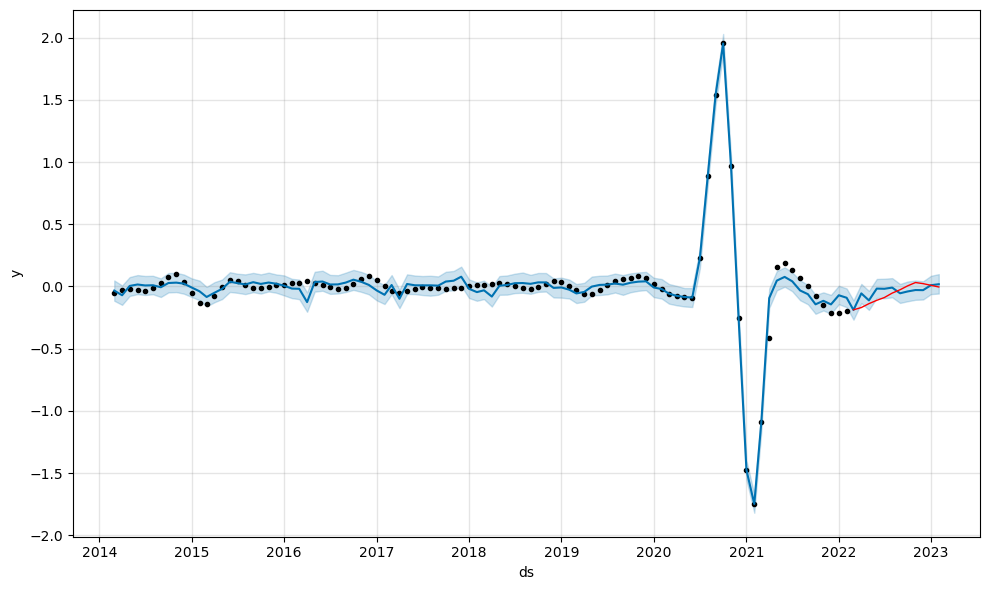

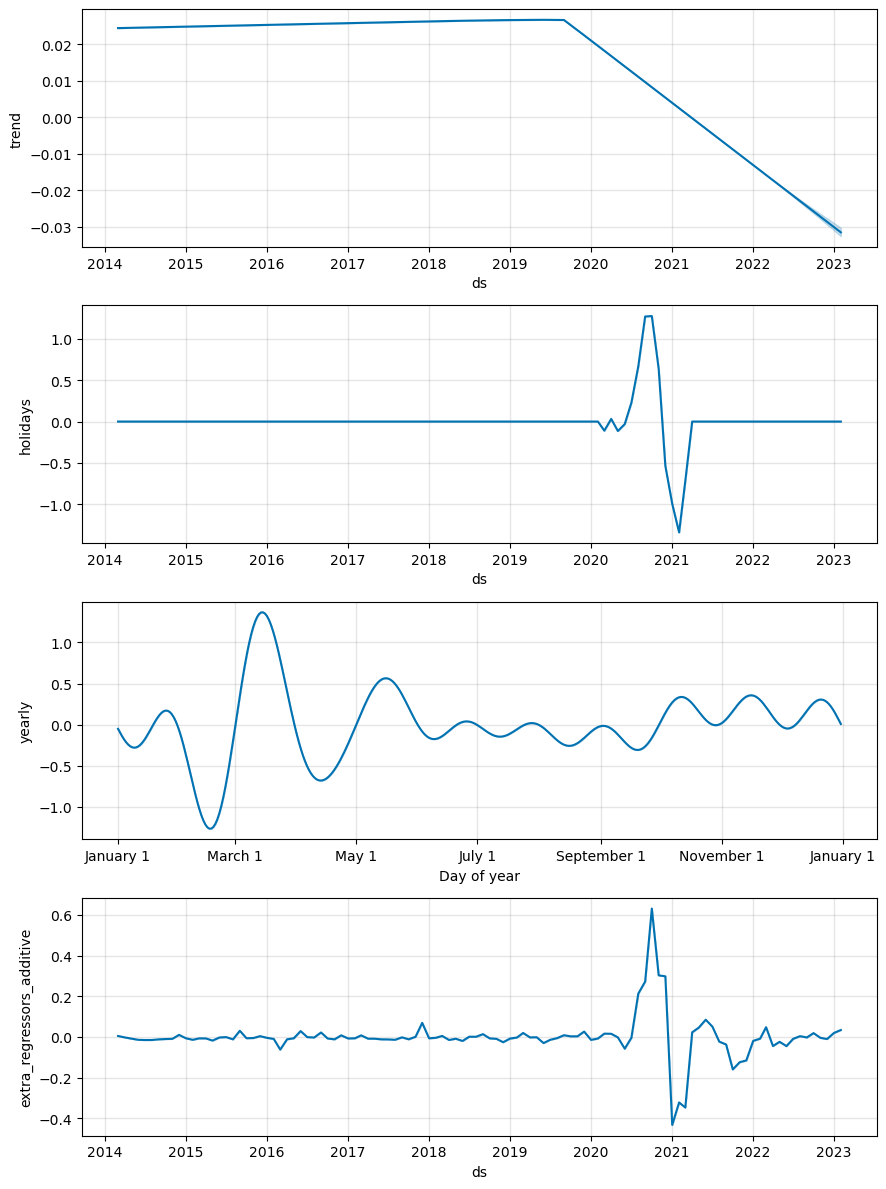

In [47]:

regressors = ['Productivity_Norm_Diff_lag_5', 'GDP_Norm_Diff_lag_7', 'Interest Rate Norm Diff2 lag 3']
list_of_features = ['Month','Year', 'PE_Norm_Diff']
list_of_features += regressors

dataset = pd.read_csv('./datasets/train.csv')
validation = pd.read_csv('./datasets/test.csv')
merged = pd.read_csv('./datasets/merged.csv')
merged.drop(["Unnamed: 0"], inplace=True, axis=1)
dataset.drop(["Unnamed: 0"], inplace=True, axis=1)
validation.drop(["Unnamed: 0"], inplace=True, axis=1)
validation = validation[list_of_features]
dataset = dataset[list_of_features]
merged = merged[list_of_features]
dataset['Date'] = dataset['Year'].astype(str) + "-" + dataset['Month'].astype(str)
validation['Date'] = validation['Year'].astype(str) + "-" +validation['Month'].astype(str)
dataset.drop(["Month", "Year"], inplace=True, axis=1)
validation.drop(["Month", "Year"], inplace=True, axis=1)
dataset = dataset.rename(columns={"Date":"ds", "PE_Norm_Diff":"y"})
validation = validation.rename(columns={"Date":"ds", "PE_Norm_Diff":"y"})

model = Prophet(holidays=lockdowns)
# model = Prophet()
for regressor in regressors:
    model.add_regressor(regressor)
model.fit(dataset)
future = model.make_future_dataframe(periods=prediction_period, freq="M")
future[regressors] = merged[regressors]
forecast = model.predict(future)
fig1 = model.plot(forecast)
plt.plot(future['ds'][-prediction_period:], validation['y'][:prediction_period], color='r', linewidth=1, label="")
fig2 = model.plot_components(forecast)
unnorm = revert_norm_diff_pe(forecast['yhat'].tail(prediction_period))
mape = calculate_mape(np.array(test['PE']), unnorm)
print("MAPE: {:.2f}%".format(mape))

In [48]:

test

,Month,Year,PE
0,3,2022,26.0
1,4,2022,22.2
2,5,2022,19.1
3,6,2022,16.6
4,7,2022,14.6
5,8,2022,13.4
6,9,2022,12.8
7,10,2022,12.9
8,11,2022,13.6
9,12,2022,14.1


In [49]:
forecast.tail(prediction_period)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,GDP_Norm_Diff_lag_7,GDP_Norm_Diff_lag_7_lower,GDP_Norm_Diff_lag_7_upper,Interest Rate Norm Diff2 lag 3,...,lockdown_1,lockdown_1_lower,lockdown_1_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
96,2022-02-28,-0.015818,-0.267854,-0.112792,-0.015824,-0.015812,-0.024850,-0.024850,-0.024850,-0.000961,...,0.0,0.0,0.0,-0.221735,-0.221735,-0.221735,0.0,0.0,0.0,-0.189836
97,2022-03-31,-0.017266,-0.133515,0.020369,-0.017305,-0.017221,-0.031852,-0.031852,-0.031852,-0.010294,...,0.0,0.0,0.0,0.006073,0.006073,0.006073,0.0,0.0,0.0,-0.056094
98,2022-04-30,-0.018668,-0.189187,-0.035711,-0.018754,-0.018558,-0.023161,-0.023161,-0.023161,0.001773,...,0.0,0.0,0.0,-0.069622,-0.069622,-0.069622,0.0,0.0,0.0,-0.112433
99,2022-05-31,-0.020116,-0.092250,0.060171,-0.020273,-0.019933,-0.011854,-0.011854,-0.011854,0.004910,...,0.0,0.0,0.0,0.047947,0.047947,0.047947,0.0,0.0,0.0,-0.017465
100,2022-06-30,-0.021517,-0.095234,0.061920,-0.021755,-0.021245,-0.001685,-0.001685,-0.001685,-0.005154,...,0.0,0.0,0.0,0.012113,0.012113,0.012113,0.0,0.0,0.0,-0.018998
101,2022-07-31,-0.022965,-0.087851,0.066682,-0.023300,-0.022589,0.001653,0.001653,0.001653,0.004744,...,0.0,0.0,0.0,0.009800,0.009800,0.009800,0.0,0.0,0.0,-0.009523
102,2022-08-31,-0.024413,-0.132899,0.019519,-0.024843,-0.023917,0.003852,0.003852,0.003852,-0.008883,...,0.0,0.0,0.0,-0.028165,-0.028165,-0.028165,0.0,0.0,0.0,-0.055278
103,2022-09-30,-0.025814,-0.119270,0.039547,-0.026344,-0.025186,0.005955,0.005955,0.005955,0.015494,...,0.0,0.0,0.0,-0.033321,-0.033321,-0.033321,0.0,0.0,0.0,-0.040441
104,2022-10-31,-0.027262,-0.107644,0.047162,-0.027895,-0.026476,0.007484,0.007484,0.007484,-0.009201,...,0.0,0.0,0.0,0.002702,0.002702,0.002702,0.0,0.0,0.0,-0.029031
105,2022-11-30,-0.028663,-0.105402,0.041085,-0.029430,-0.027703,0.008919,0.008919,0.008919,-0.021661,...,0.0,0.0,0.0,0.009078,0.009078,0.009078,0.0,0.0,0.0,-0.029997


In [50]:
unnorm

array([22.05336494, 20.79853744, 18.28340998, 17.89271721, 17.46773658,
       17.25471471, 16.01815193, 15.11348727, 14.46406582, 13.79303443,
       14.01432519, 14.40859501])

In [51]:
test['PE']

0     26.0
1     22.2
2     19.1
3     16.6
4     14.6
5     13.4
6     12.8
7     12.9
8     13.6
9     14.1
10    14.3
11    14.2
Name: PE, dtype: float64

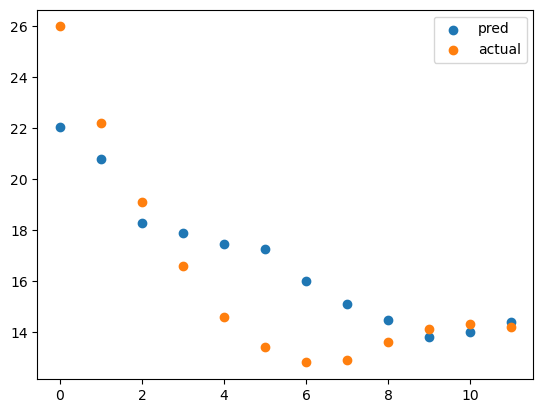

In [52]:
x = np.arange(12)
plt.scatter(x,unnorm,label="pred")
plt.scatter(x,test['PE'],label="actual")
plt.legend()

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107]
[ 96  97  98  99 100 101 102 103 104 105 106 107]


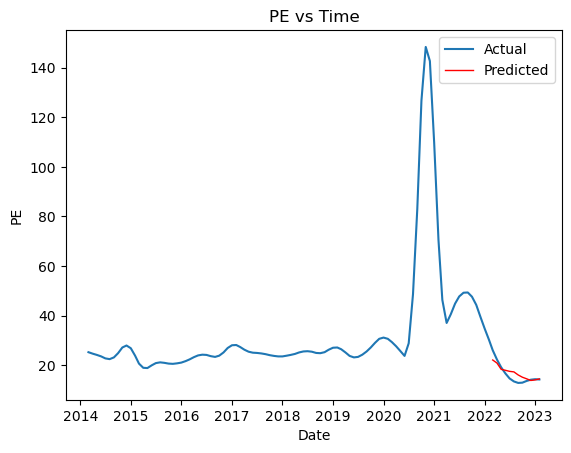

In [53]:
dataset = pd.read_csv('./datasets/merged.csv')
validation_plot = pd.read_csv('./datasets/test.csv')
x = np.arange(108)
x2 = np.arange(96,108)
print(x)
print(x2)
plt.plot(future['ds'],dataset['PE'][0:108], label="Actual")
plt.plot(future['ds'][-prediction_period:],unnorm, color='r', linewidth=1, label="Predicted")
plt.title("PE vs Time")
plt.xlabel("Date")
plt.ylabel("PE")
plt.legend()

In [25]:
dataset

,Unnamed: 0,Month,Year,Unemployment,Unemployment_Norm,Unemployment_Norm_Diff,Unemployment_Norm_Diff_lag_1,Unemployment_Norm_Diff_lag_2,Unemployment_Norm_Diff_lag_3,Unemployment_Norm_Diff_lag_4,...,PE_Norm_Diff,PE_mean,PE_std,PE_original_value,Absolute PE_Norm,Absolute PE_Norm_Diff,PS_Norm,PS_Norm_Diff,Month_sin,Month_cos
0,0,3,2014,6.6,-0.057124,-0.083845,-0.041922,-0.125767,0.000000,0.000000,...,-0.049173,30.608108,22.370005,-0.192584,-0.329008,-0.020703,0.041933,0.000000,1.000000e+00,6.123234e-17
1,1,4,2014,6.4,-0.140969,-0.083845,-0.083845,-0.041922,-0.125767,0.000000,...,-0.026822,30.608108,22.370005,-0.192584,-0.353852,-0.024843,0.041933,0.000000,8.660254e-01,-5.000000e-01
2,2,5,2014,6.3,-0.182892,-0.041922,-0.083845,-0.083845,-0.041922,-0.125767,...,-0.022351,30.608108,22.370005,-0.192584,-0.374555,-0.020703,0.041933,0.000000,5.000000e-01,-8.660254e-01
3,3,6,2014,6.1,-0.266737,-0.083845,-0.041922,-0.083845,-0.083845,-0.041922,...,-0.026822,30.608108,22.370005,-0.192584,-0.386976,-0.012422,0.041933,0.000000,1.224647e-16,-1.000000e+00
4,4,7,2014,6.0,-0.308659,-0.041922,-0.083845,-0.041922,-0.083845,-0.083845,...,-0.035762,30.608108,22.370005,-0.192584,-0.399398,-0.012422,-0.216652,-0.258585,-5.000000e-01,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,91,10,2021,4.1,-1.105185,-0.041922,-0.041922,-0.041922,-0.083845,-0.041922,...,-0.075995,30.608108,22.370005,-0.192584,0.039503,-0.082812,1.334856,-0.517169,-8.660254e-01,5.000000e-01
92,92,11,2021,4.0,-1.147108,-0.041922,-0.041922,-0.041922,-0.041922,-0.083845,...,-0.147519,30.608108,22.370005,-0.192584,-0.146823,-0.186326,0.817686,-0.517169,-5.000000e-01,8.660254e-01
93,93,12,2021,4.0,-1.147108,0.000000,-0.041922,-0.041922,-0.041922,-0.041922,...,-0.214573,30.608108,22.370005,-0.192584,-0.333149,-0.186326,0.559102,-0.258585,-2.449294e-16,1.000000e+00
94,94,1,2022,3.8,-1.230953,-0.083845,0.000000,-0.041922,-0.041922,-0.041922,...,-0.214573,30.608108,22.370005,-0.192584,-0.519475,-0.186326,0.300517,-0.258585,5.000000e-01,8.660254e-01
